# Setup

## Imports & Settings

In [2]:
%load_ext autoreload
%autoreload 2

import os
import re
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Column Names (from Metadata & To Be Created)
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
col_subject = "Patient"  # in metadata file
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_condition = "Condition"  # constructed from col_inflamed & col_stricture
col_fff = "file_path"  # column in metadata in which to store data file path
col_tangram = "tangram_prediction"  # for future Tangram imputation annotation

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options & Data

In [4]:
# Directories & Metadata
load, reannotate = False, True
run = ["CHO-010", "CHO-010", "CHO-009"]
# run = ["CHO-001", "CHO-002"]
# run = ["CHO-001", "CHO-002", "CHO-005", "CHO-006", "CHO-007"]
# samples = "all"
# samples = ["50564A4", "50618B5"]
# samples = ["50007B2"]
# samples = ["50006B", "50006A", "50006C"]
# samples = ["50217B", "50217A", "50217C"]
samples = ["50336C", "50336B", "50336A"]
# samples = ["50452A", "50452B", "50452C"]
# samples = ["50564A4", "50618B5"]

# Optionally, Define Manual Annotation Versions
# should be stored in ("<out_dir>/annotations_dictionaries")
# in format <selves[i]._library_id>___leiden_<man_anns[i]>_dictionary.xlsx
# with first column = leiden cluster and second column = annotation
man_anns = True  # load manual annotations according to clustering kws
# man_anns = ["res0pt5_dist0pt5_npc30", "res0pt75_dist0pt3_npc30",
#             "res1pt5_dist0_npc30"]  # choose manual annotations to load
# man_anns = None  # do not load manual annotations

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
ddx = f"{ddm}/bbdata1"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")  # None = no save
d_path = os.path.join(ddm, "disk2" if "cho" in ddm else "",
                      os.getlogin(), "data")  # other, e.g., Tangram data
anf = pd.read_csv(os.path.join(ddu, "corescpy/examples/markers_lineages.csv"))
file_mdf = os.path.join(ddl, "samples.csv")  # metadata

# Annotation & Tangram Imputation
col_assignment = "Bin"  # which column from annotation file to use
# col_cell_type_sc, file_sc = "ClusterAnnotation", str(
#     f"{d_path}/2023-05-12_CombinedCD-v2_ileal_new.h5ad")
col_cell_type_sc, file_sc = "cell_type", f"{d_path}/elmentaite_ileal.h5ad"
# file_sc = None  # to skip Tangram imputation/label transfer

# Processing & Clustering Options
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[15, None],
              cell_filter_ngene=[3, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              method_norm="log")  # preprocessing keyword arguments
kws_cluster = dict(kws_umap=dict(method="rapids" if gpu else "umap"),
                   genes_subset=list(anf.iloc[:, 0]),  # use only markers
                   use_gpu=gpu, use_highly_variable=False)
kws_clustering, col_assignment = {}, []
for i in zip([0.5, 0.75, 1.5], [0.5, 0.3, 0], [30, 30, 30]):
    kws = {**kws_cluster, "resolution": i[0], "kws_umap": {
        **kws_cluster["kws_umap"], "min_dist": i[1]}, "n_comps": i[2]}
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})
    col_assignment += ["group" if kws["resolution"] >= 0.7 else "Bucket"]
if man_anns is True:
    man_anns = list(kws_clustering.keys())
col_cell_type = list(kws_clustering.keys())[-1] if (
    man_anns is None) else f"manual_{man_anns[-1]}"  # default cell labels

# After this point, no more options to specify
# Just code to infer the data file path from your specifications
# and construct argument dictionaries and manipulate metadata and such.

# Read Metadata & Other Information
metadata = (pd.read_excel if file_mdf[-4:] == "xlsx" else pd.read_csv)(
    file_mdf, dtype={"Slide ID": str}).rename({
        "Name": col_subject, "Inflammation": col_inflamed}, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_o).loc[samples].reset_index()

# Revise Metadata & Construct Variables from Options
metadata.loc[:, col_condition] = metadata.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
metadata.loc[:, col_sample_id] = metadata[[col_condition, col_sample_id_o]
                                          ].apply("-".join, axis=1)
metadata = metadata.set_index(col_sample_id)
fff = np.array(cr.pp.construct_file(run=run, directory=ddx))
bff = np.array([os.path.basename(i) for i in fff])  # base path names
samps = np.array([i.split("__")[2].split("-")[0] for i in fff])
for x in metadata[col_sample_id_o]:
    m_f = metadata[metadata[col_sample_id_o] == x][
        "out_file"].iloc[0]  # ...use to find unconventionally-named files
    locx = np.where(samps == x)[0] if pd.isnull(
        m_f) else np.where(bff == m_f)[0]
    metadata.loc[metadata[col_sample_id_o] == x, col_fff] = fff[locx[0]] if (
        len(locx) > 0) else np.nan  # assign output file to metadata row
metadata = metadata.dropna(subset=[col_fff]).drop_duplicates()

# Annotation File
assign = anf.dropna(subset=col_assignment).set_index(
    "gene").rename_axis("Gene")  # markers
assign = assign[~assign.Quality.isin([-1])]  # drop low-quality markers

# Print Metadata & Make Output Directory (If Not Present)
print(metadata)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load Data
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cell_type)  # object creation arguments
selves = [None] * metadata.shape[0]  # to hold different samples
for i, x in enumerate(metadata.index.values):
    selves[i] = cr.Spatial(metadata.loc[x][col_fff], library_id=x, **kws_init)
    for j in metadata:  # iterate metadata columns
        selves[i].rna.obs.loc[:, j] = str(metadata.loc[x][j])  # add to object
    selves[i].rna.obs.loc[:, "out_file"] = os.path.join(
        out_dir, selves[i]._library_id)  # output path (to save object)
    if load is True:
        selves[i].update_from_h5ad(str(selves[i].rna.obs.out_file.iloc[0]))
        print(selves[i].rna)

# Marker Gene Dictionary (for Scanpy Plotting)
marker_genes_dict = dict(assign["Bucket"].reset_index().groupby(
    "Bucket").apply(lambda x: list(pd.unique(list(set(
        x.Gene).intersection(selves[0].rna.var_names))))))  # to dictionary

                  Sample ID  Patient     Status  Slide Id          Project  \
Sample                                                                       
Uninflamed-50336C    50336C    50336  Available   11047.0  scRNA & Spatial   
Inflamed-50336B      50336B    50336  Available   11044.0  scRNA & Spatial   
Stricture-50336A     50336A    50336  Available   10496.0  scRNA & Spatial   

                         Location Stricture  GRID ID    Inflamed  \
Sample                                                             
Uninflamed-50336C  Terminal Ileum        no  1011328  uninflamed   
Inflamed-50336B    Terminal Ileum        no  1011328    inflamed   
Stricture-50336A   Terminal Ileum       yes  1011328    inflamed   

                  Procedure Date  Age   Sex   Race Hispanic        Diagnosis  \
Sample                                                                         
Uninflamed-50336C        2023-11   24  male  white       NO  Crohn's Disease   
Inflamed-50336B          202

## Manual Annotations

### Load Manual Annotations

In [ ]:
if man_anns is not None and man_anns is not False:
    for i, s in enumerate(selves):
        for r in man_anns:  # iterate Leiden clusterings
            fmr = os.path.join(out_dir, "annotation_dictionaries", str(
                f"{s._library_id}___leiden_{r}_dictionary.xlsx"))  # mappings
            if os.path.exists(fmr) is False:
                print(f"{fmr} file NOT found.")
                continue
            else:
                print(f"{fmr} file found.")
            fmr = pd.read_excel(fmr).iloc[:, :2].astype(str)
            mans = dict(fmr.set_index(fmr.columns[0]).iloc[:, 0])
            s.rna.obs.loc[:, f"manual_{r}"] = s.rna.obs[f"leiden_{r}"].astype(
                int).astype(str).replace(mans)  # Leiden -> manual annotation
            s.rna.obs.loc[s.rna.obs[f"manual_{r}"].isnull(
                ), f"manual_{r}"] = s.rna.obs.loc[s.rna.obs[
                    f"manual_{r}"].isnull(), f"leiden_{r}"].astype(
                        str)  # missing annotations replaced with Leiden
            s.rna.obs.loc[:, f"manual_{r}"] = s.rna.obs[
                f"manual_{r}"].astype("category")  # as categorical
            # s.plot_spatial(f"manual_{r}")

/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Uninflamed-50336C___leiden_res0pt5_dist0pt5_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Uninflamed-50336C___leiden_res0pt75_dist0pt3_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Uninflamed-50336C___leiden_res1pt5_dist0_npc30_dictionary.xlsx file found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Inflamed-50336B___leiden_res0pt5_dist0pt5_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Inflamed-50336B___leiden_res0pt75_dist0pt3_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska

### Write Manual Annotations

In [98]:
if man_anns not in [None, False] and out_dir is not None:
    for i, s in enumerate(selves):
        for r in man_anns:
            if f"manual_{r}" in s.rna.obs:
                s.write_clusters(out_dir, col_cell_type=f"manual_{r}",
                                 overwrite=True,
                                 file_prefix=f"{s._library_id}__")
        s.write(s.rna.obs.out_file.iloc[0])

Markers File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Uninflamed-50336C___manual_res1pt5_dist0_npc30_markers.csv
Clusters File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Uninflamed-50336C___manual_res1pt5_dist0_npc30.csv




# Clustering

## Processing, Leiden, Annotation



 {'cell_filter_pmt': None, 'cell_filter_ncounts': [15, None], 'cell_filter_ngene': [3, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}, 'method_norm': 'log'} 


AnnData object with n_obs × n_vars = 387961 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_p

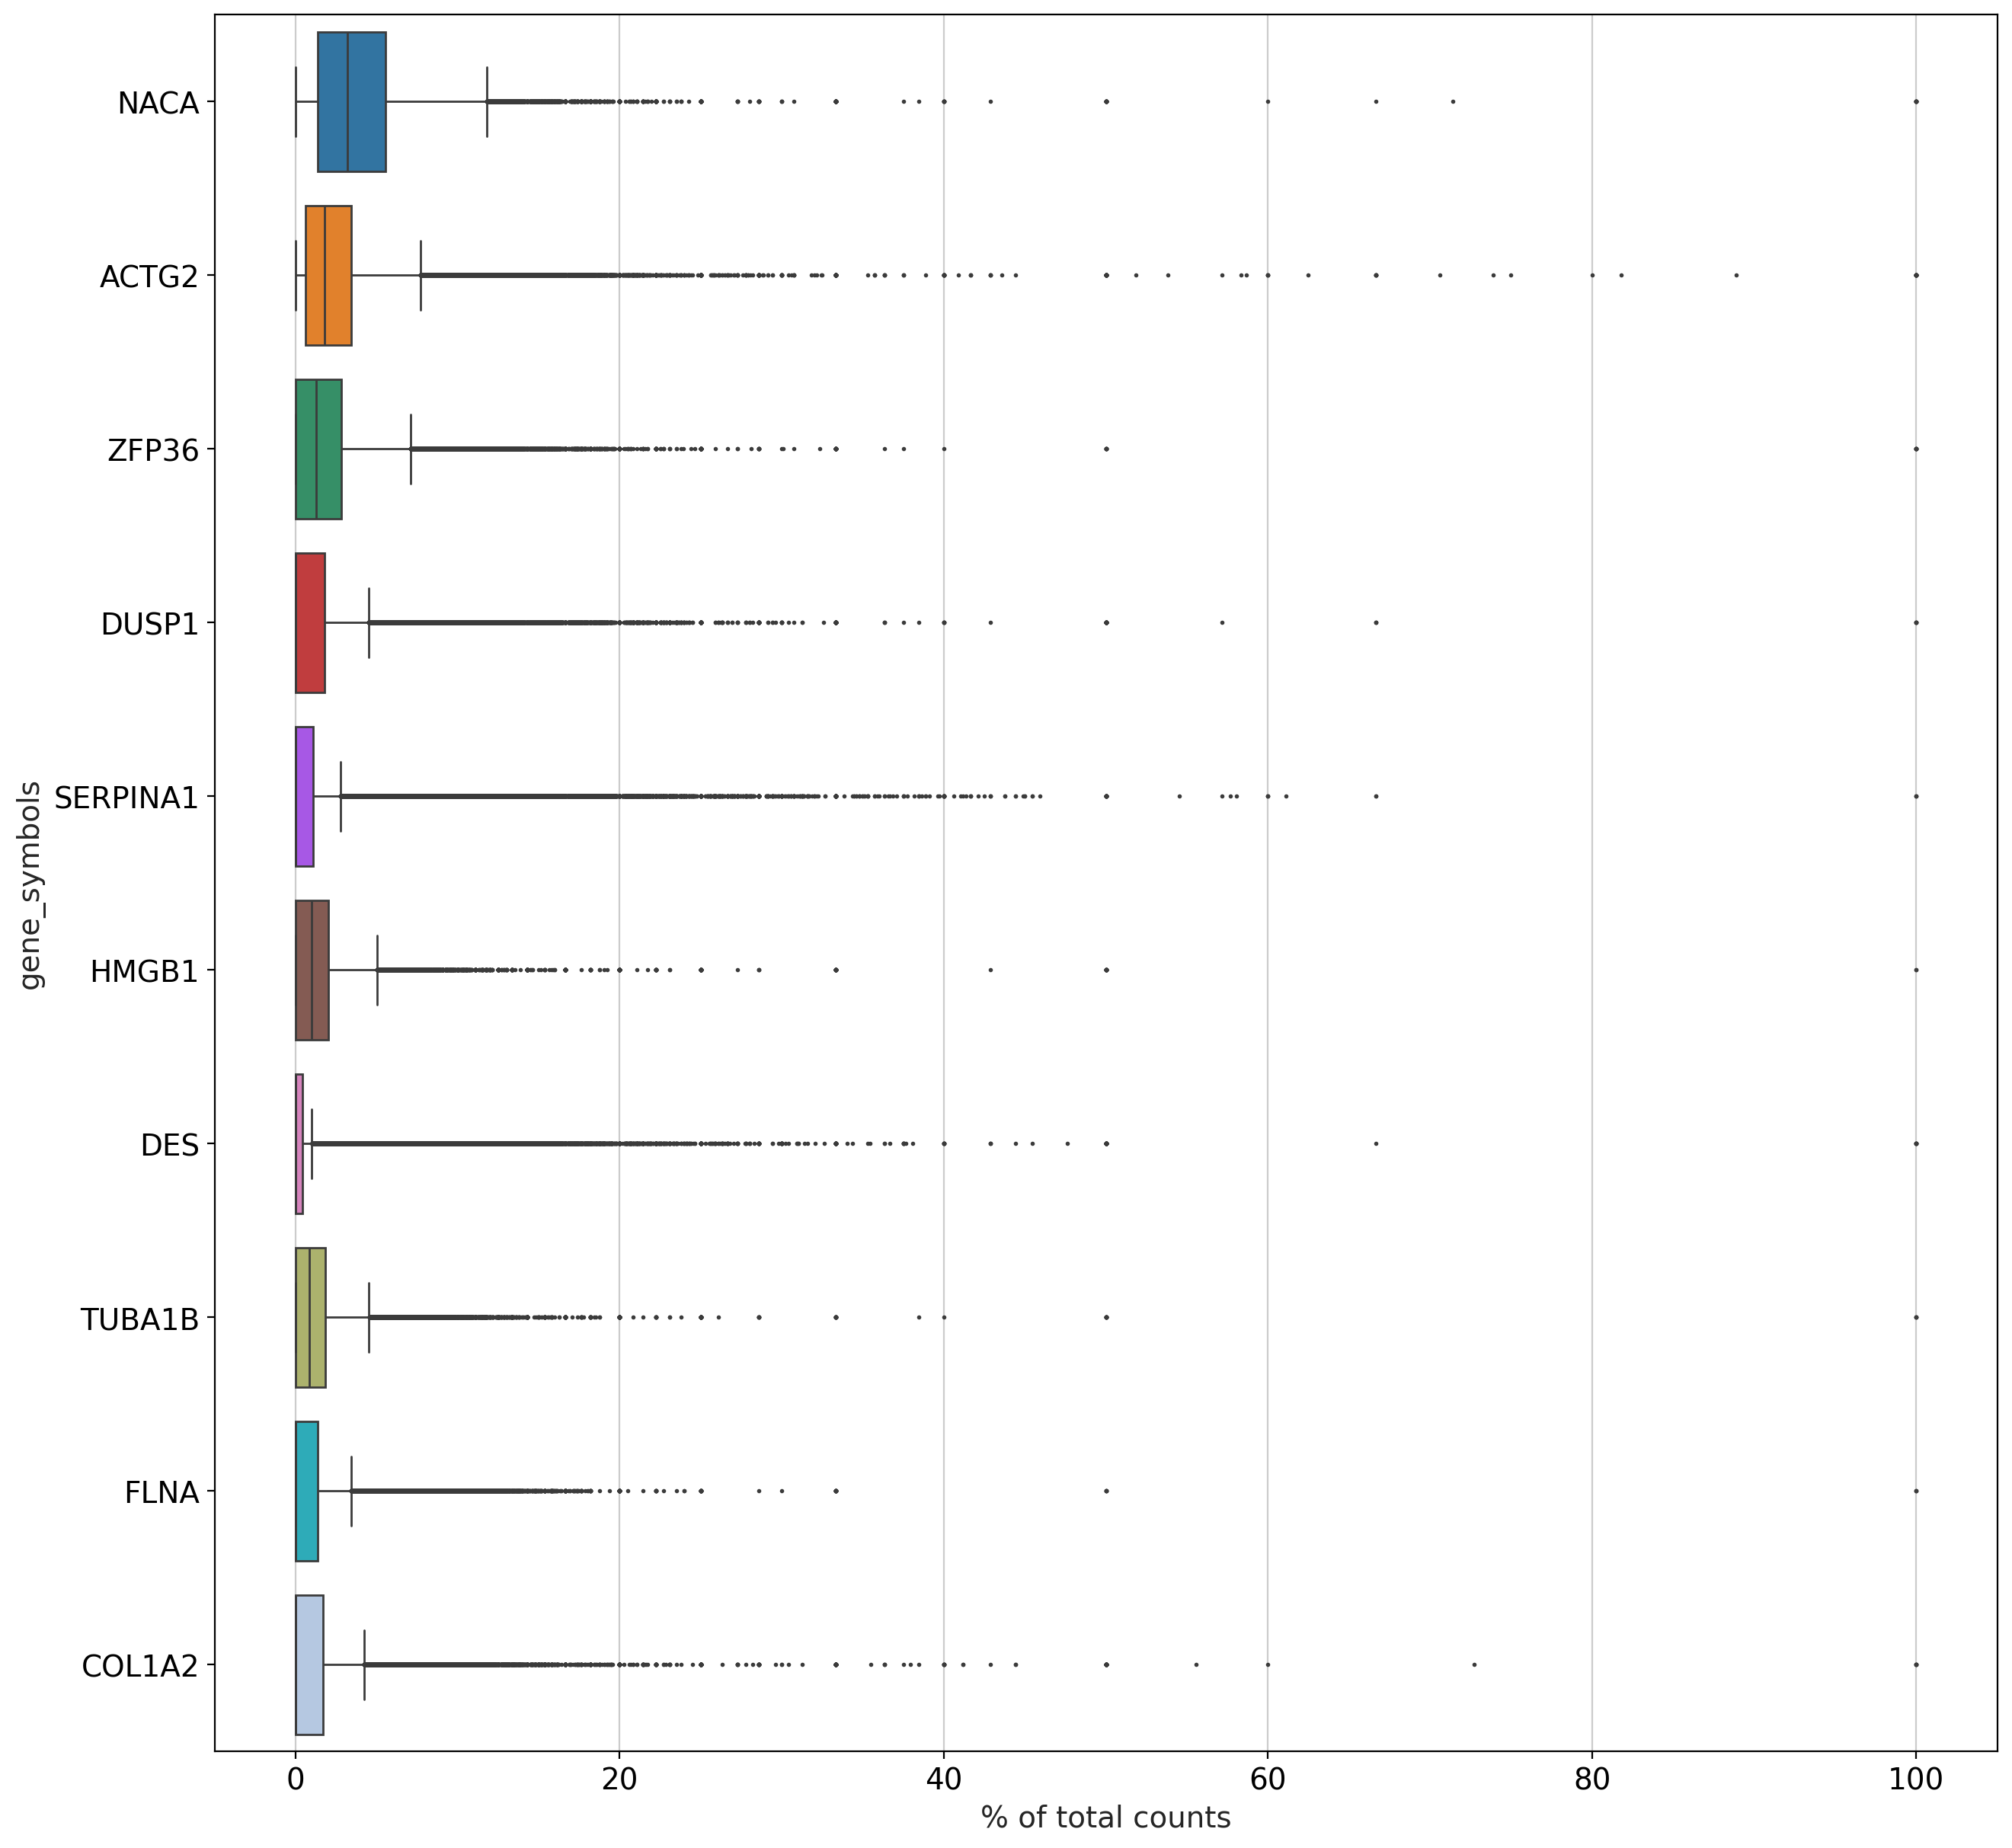

dsfasfda AnnData object with n_obs × n_vars = 387961 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'


Cell Counts: Initial


Observations: 387961



Gene Counts: Initial

Em

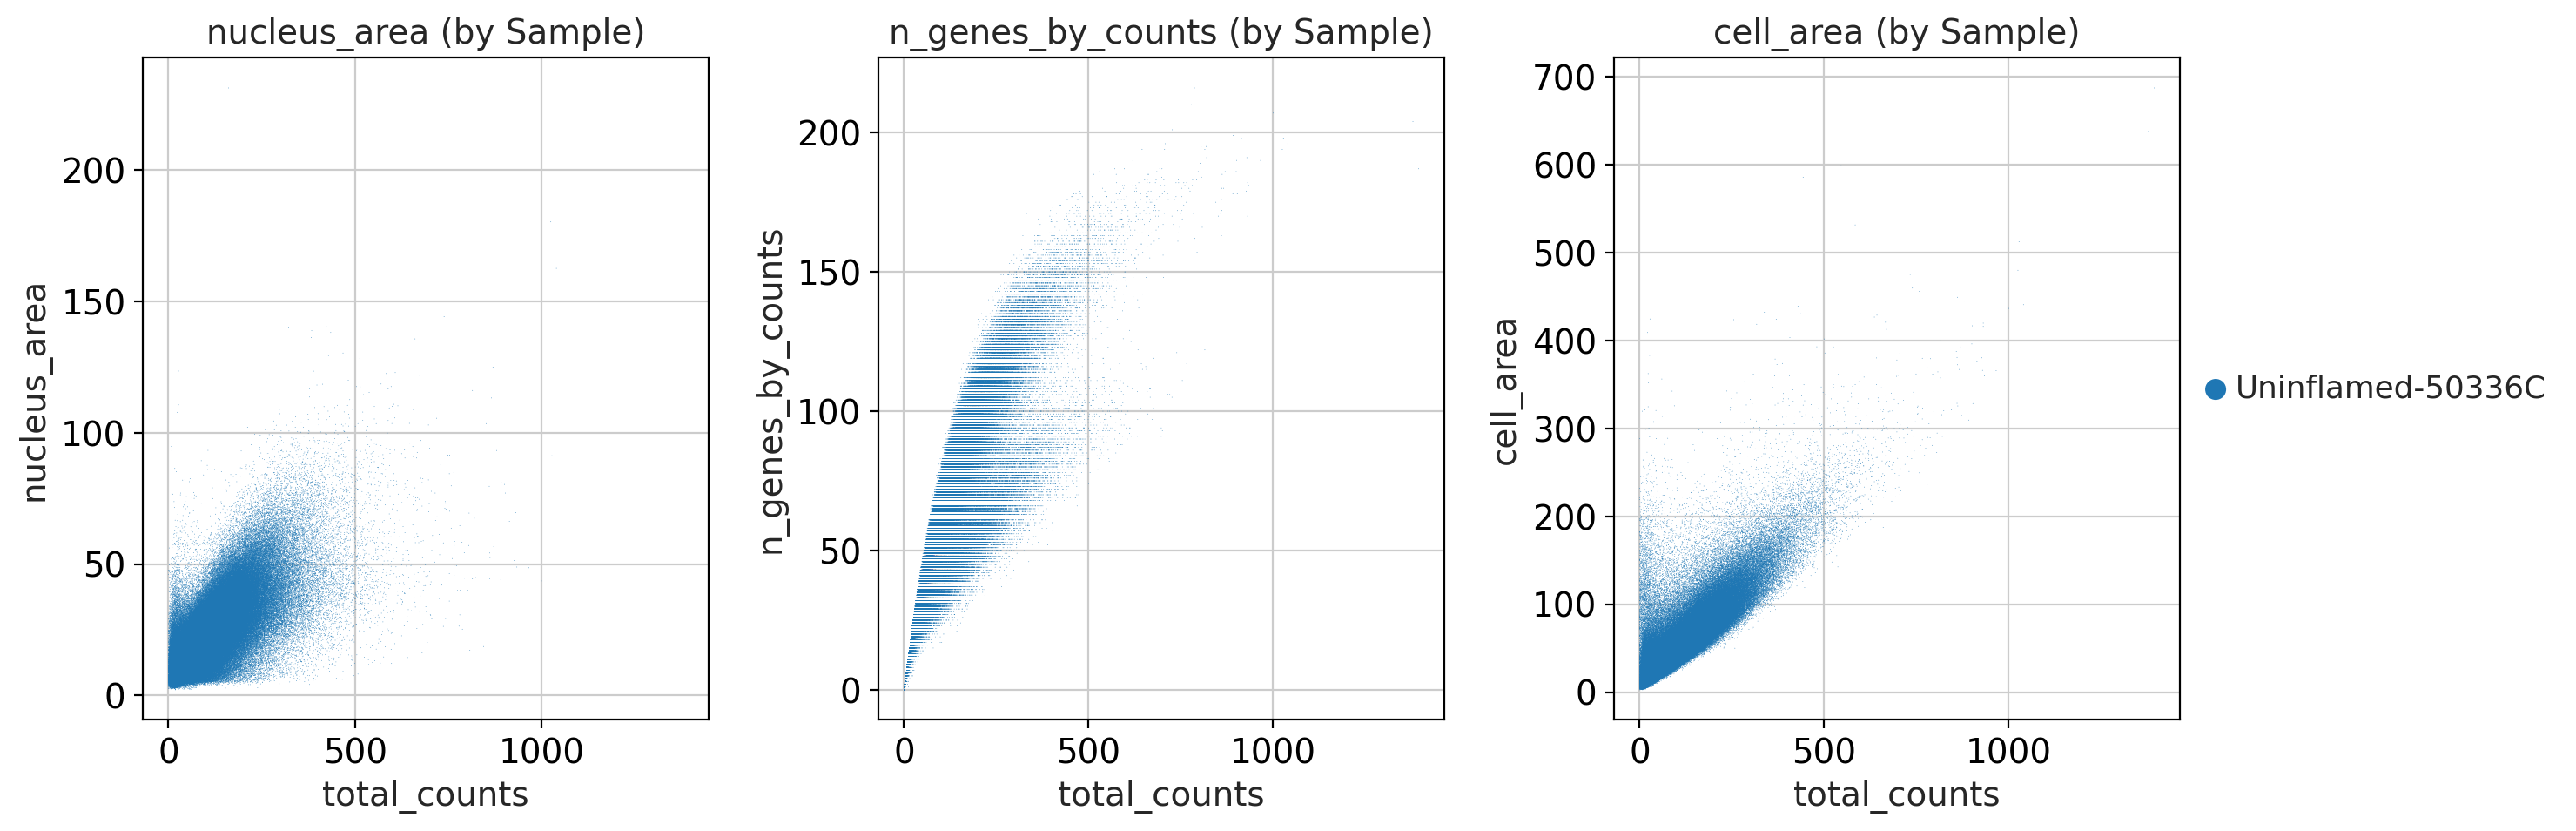


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>
dsfasfda AnnData object with n_obs × n_vars = 387035 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_c

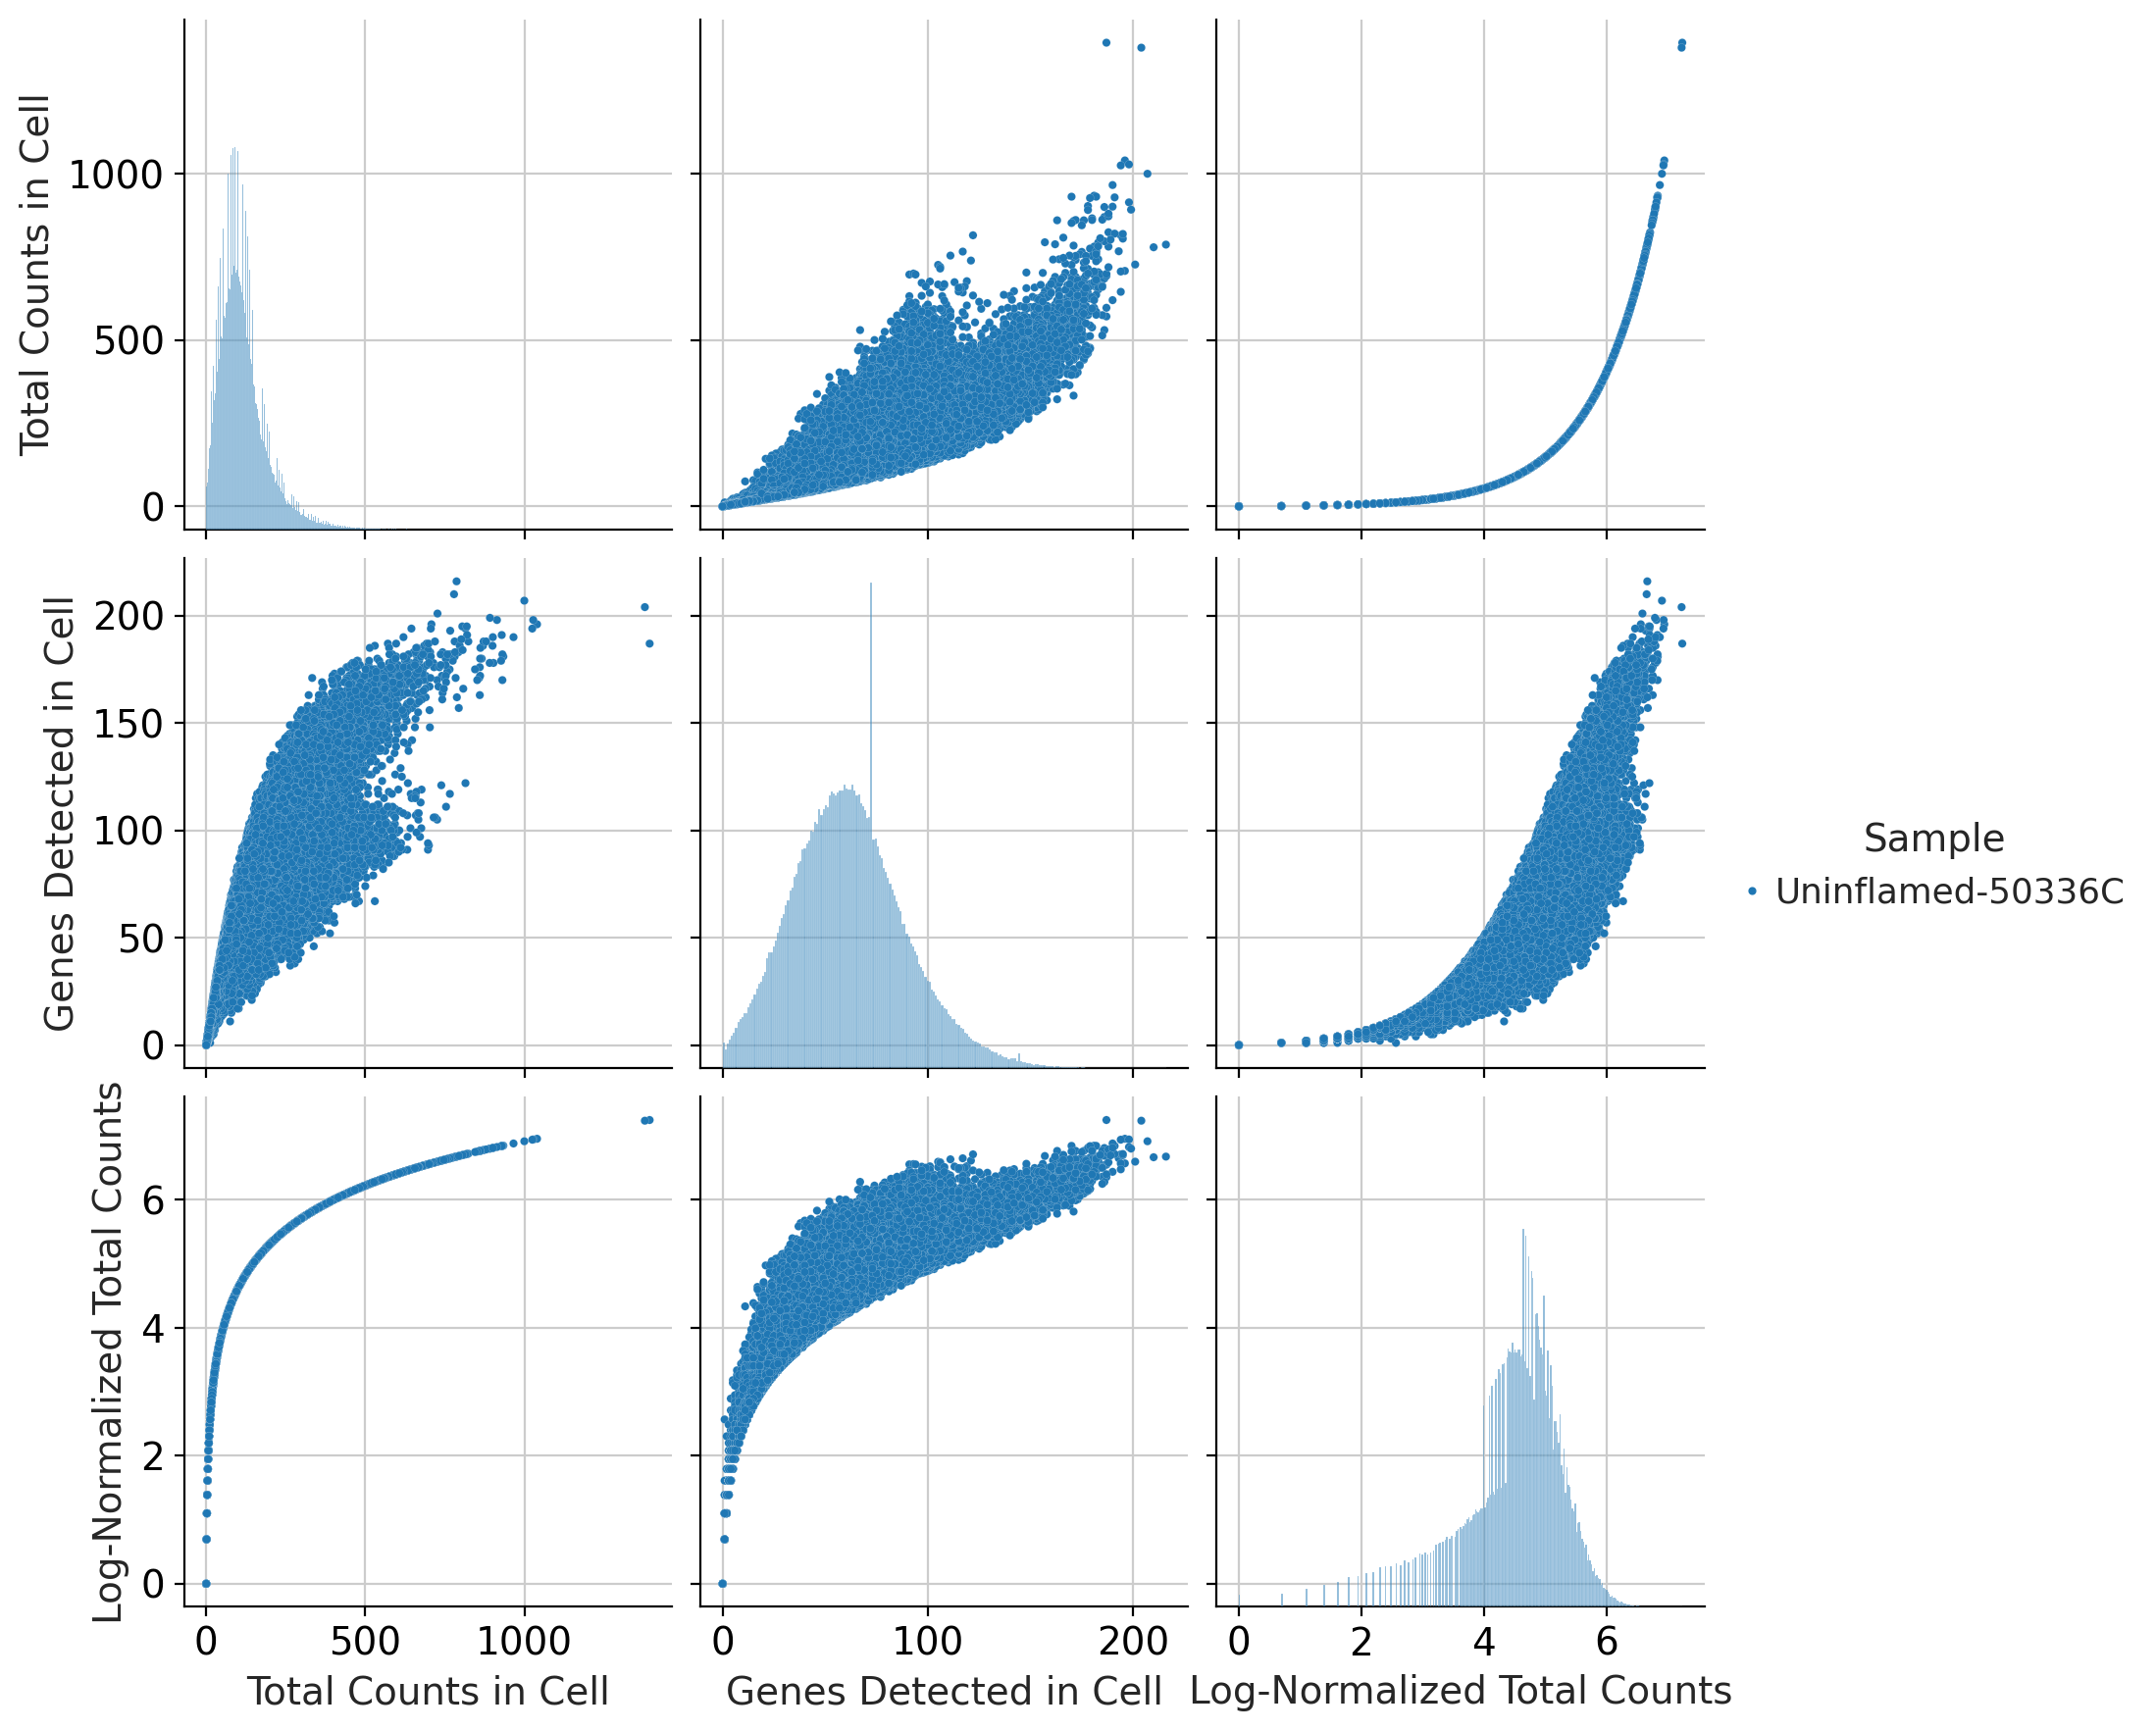

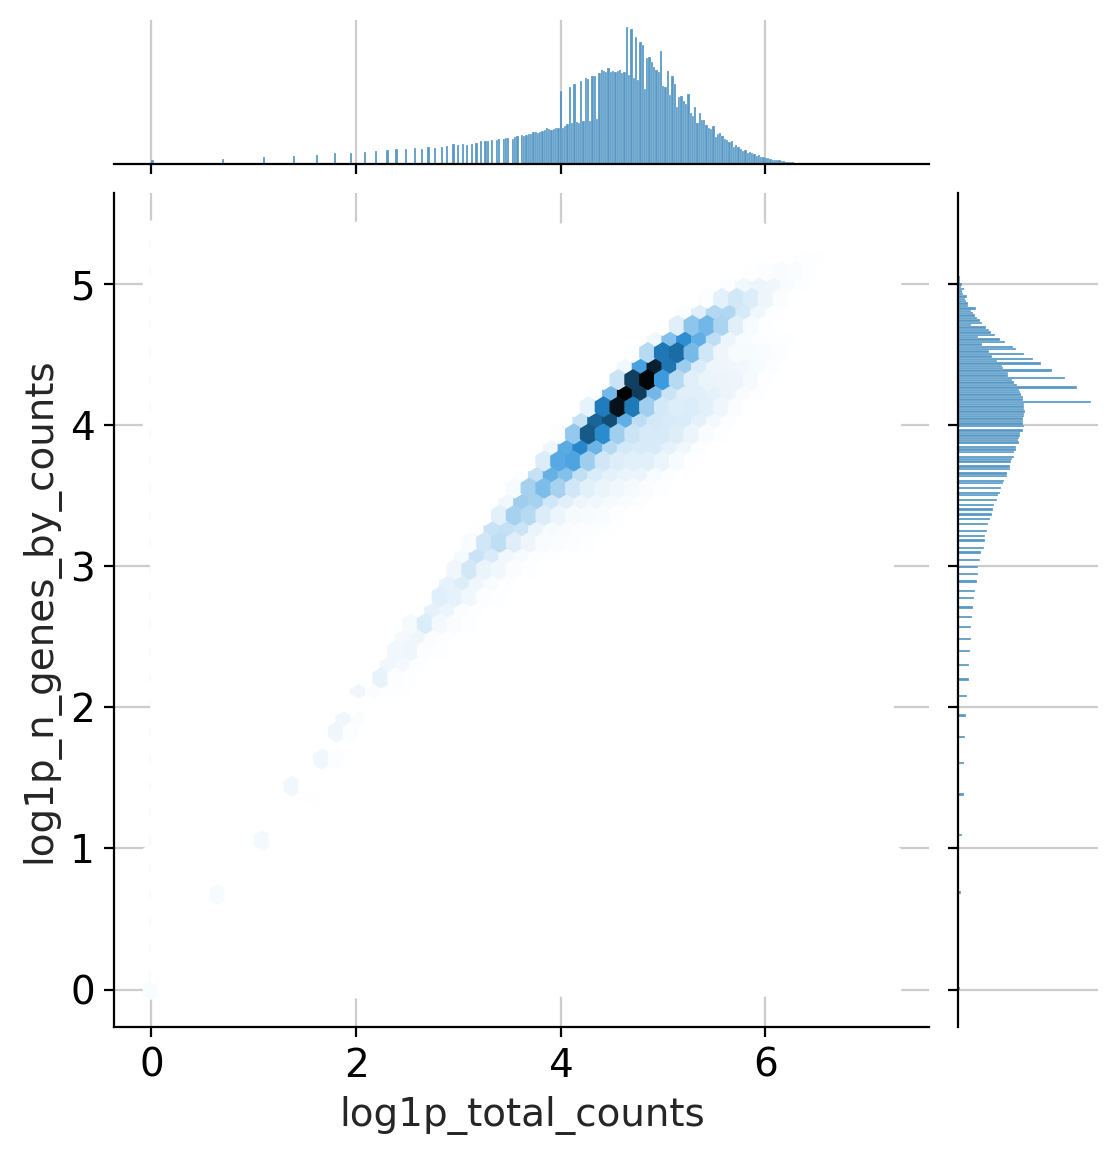

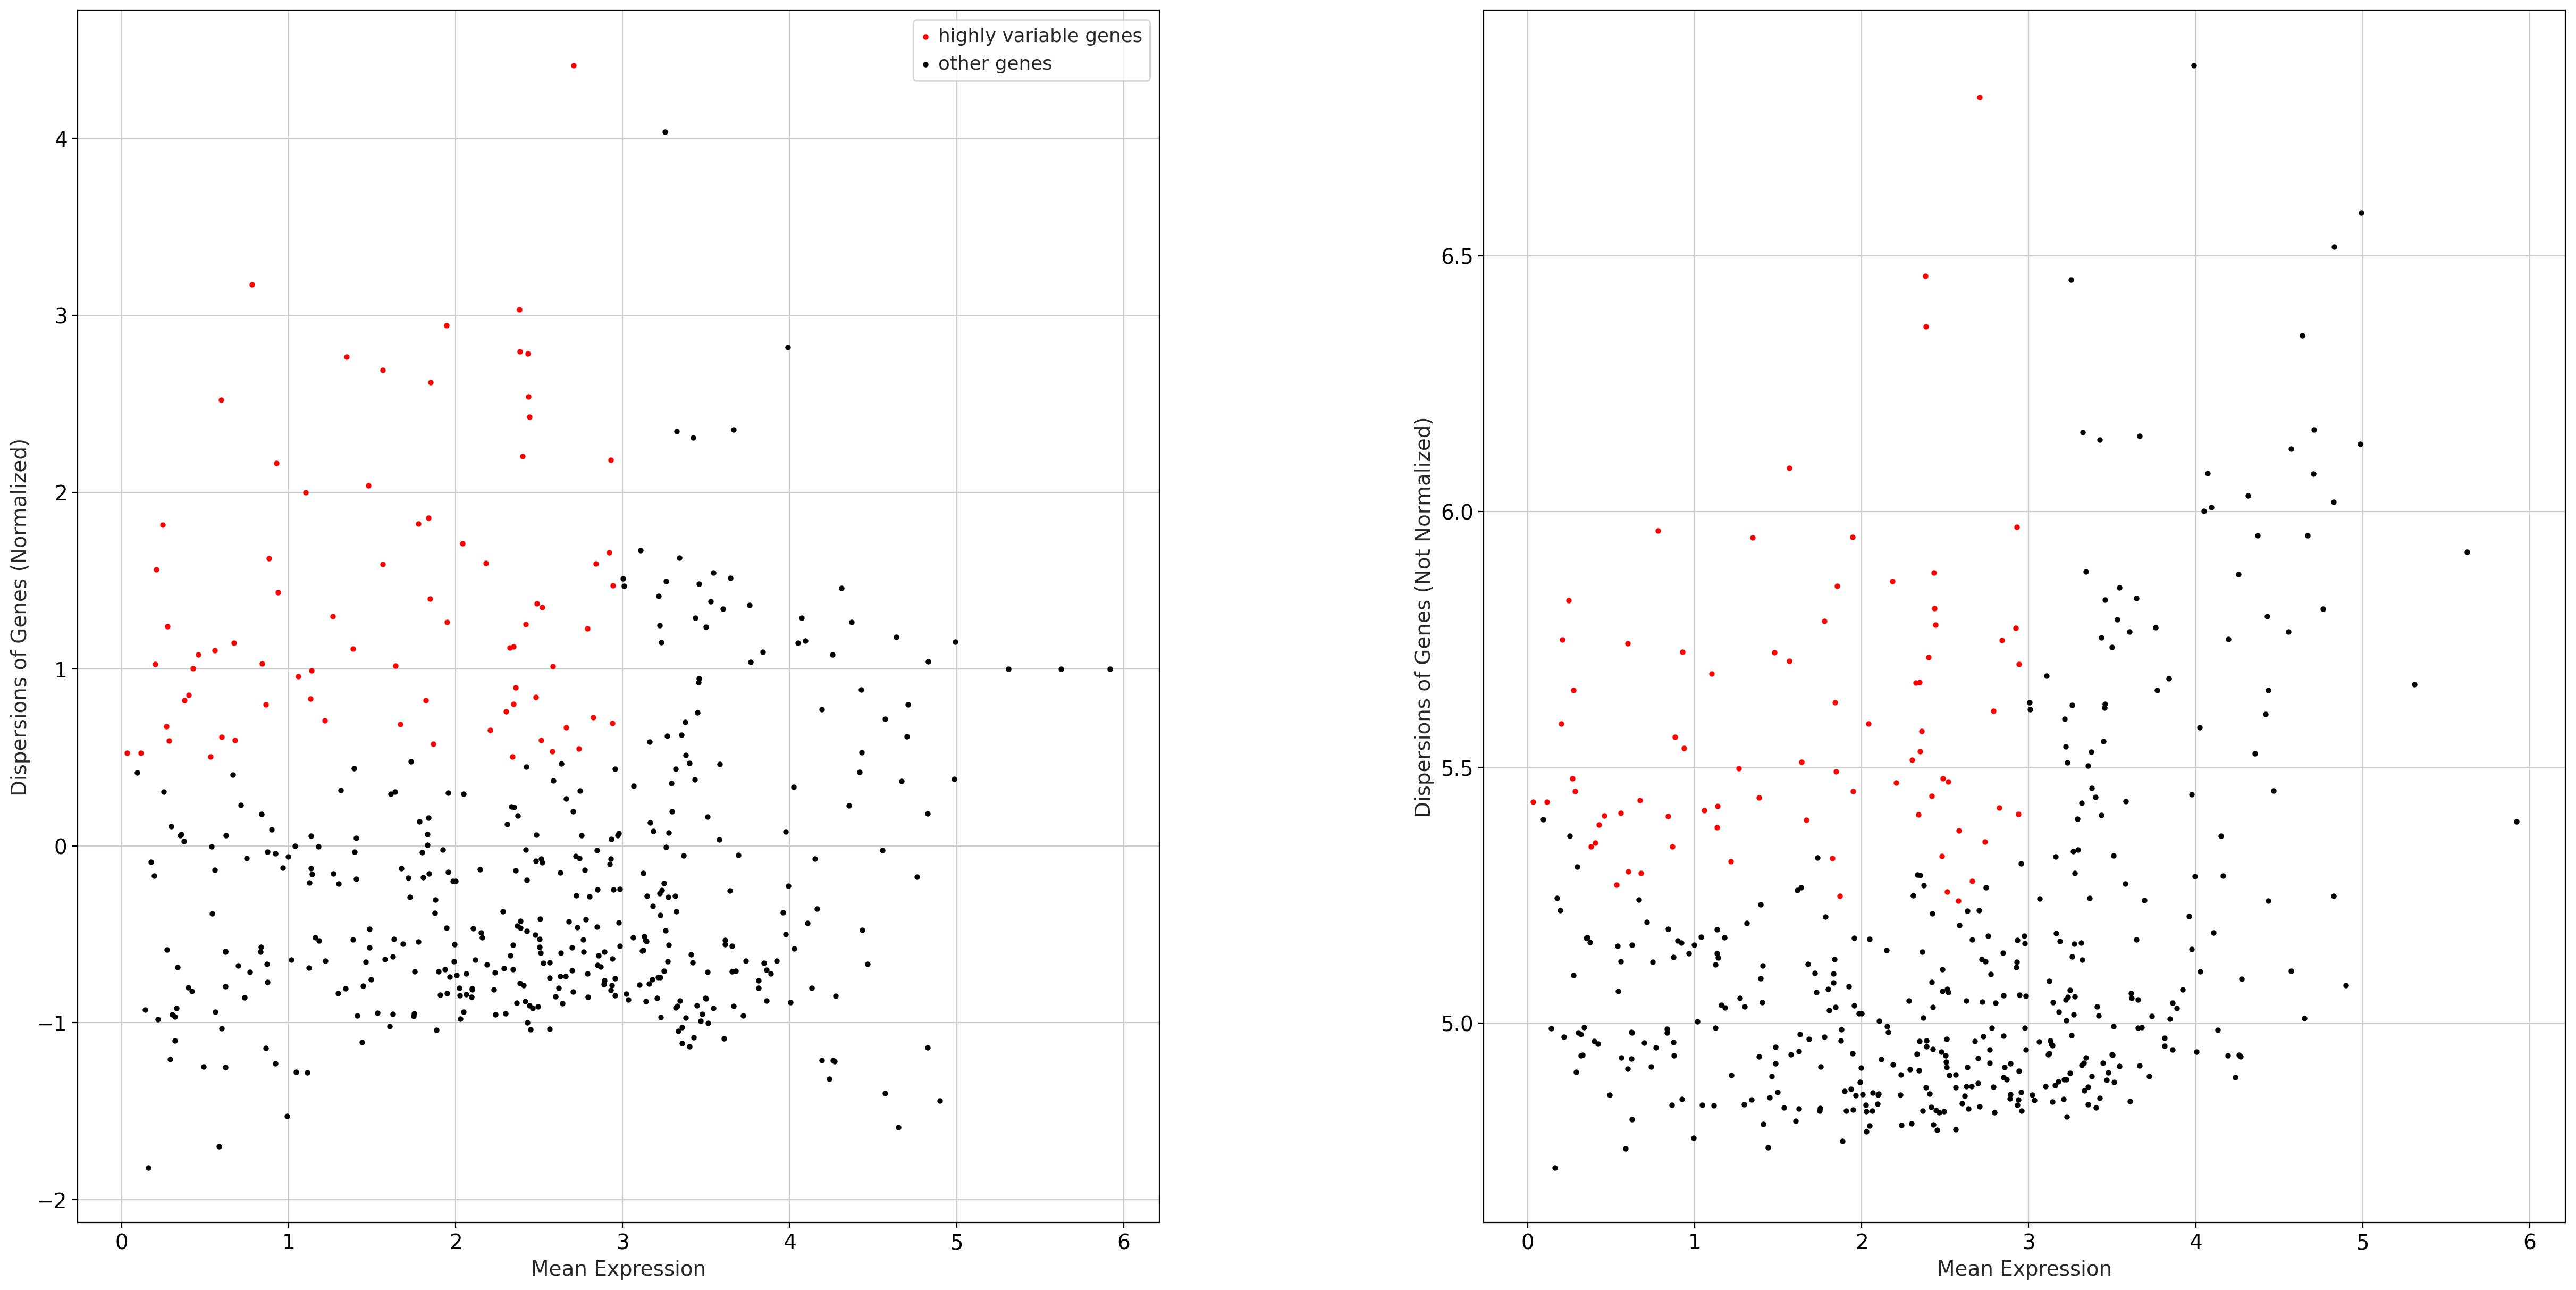


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...
dsfasfda AnnData object with n_obs × n_vars = 378219 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_c

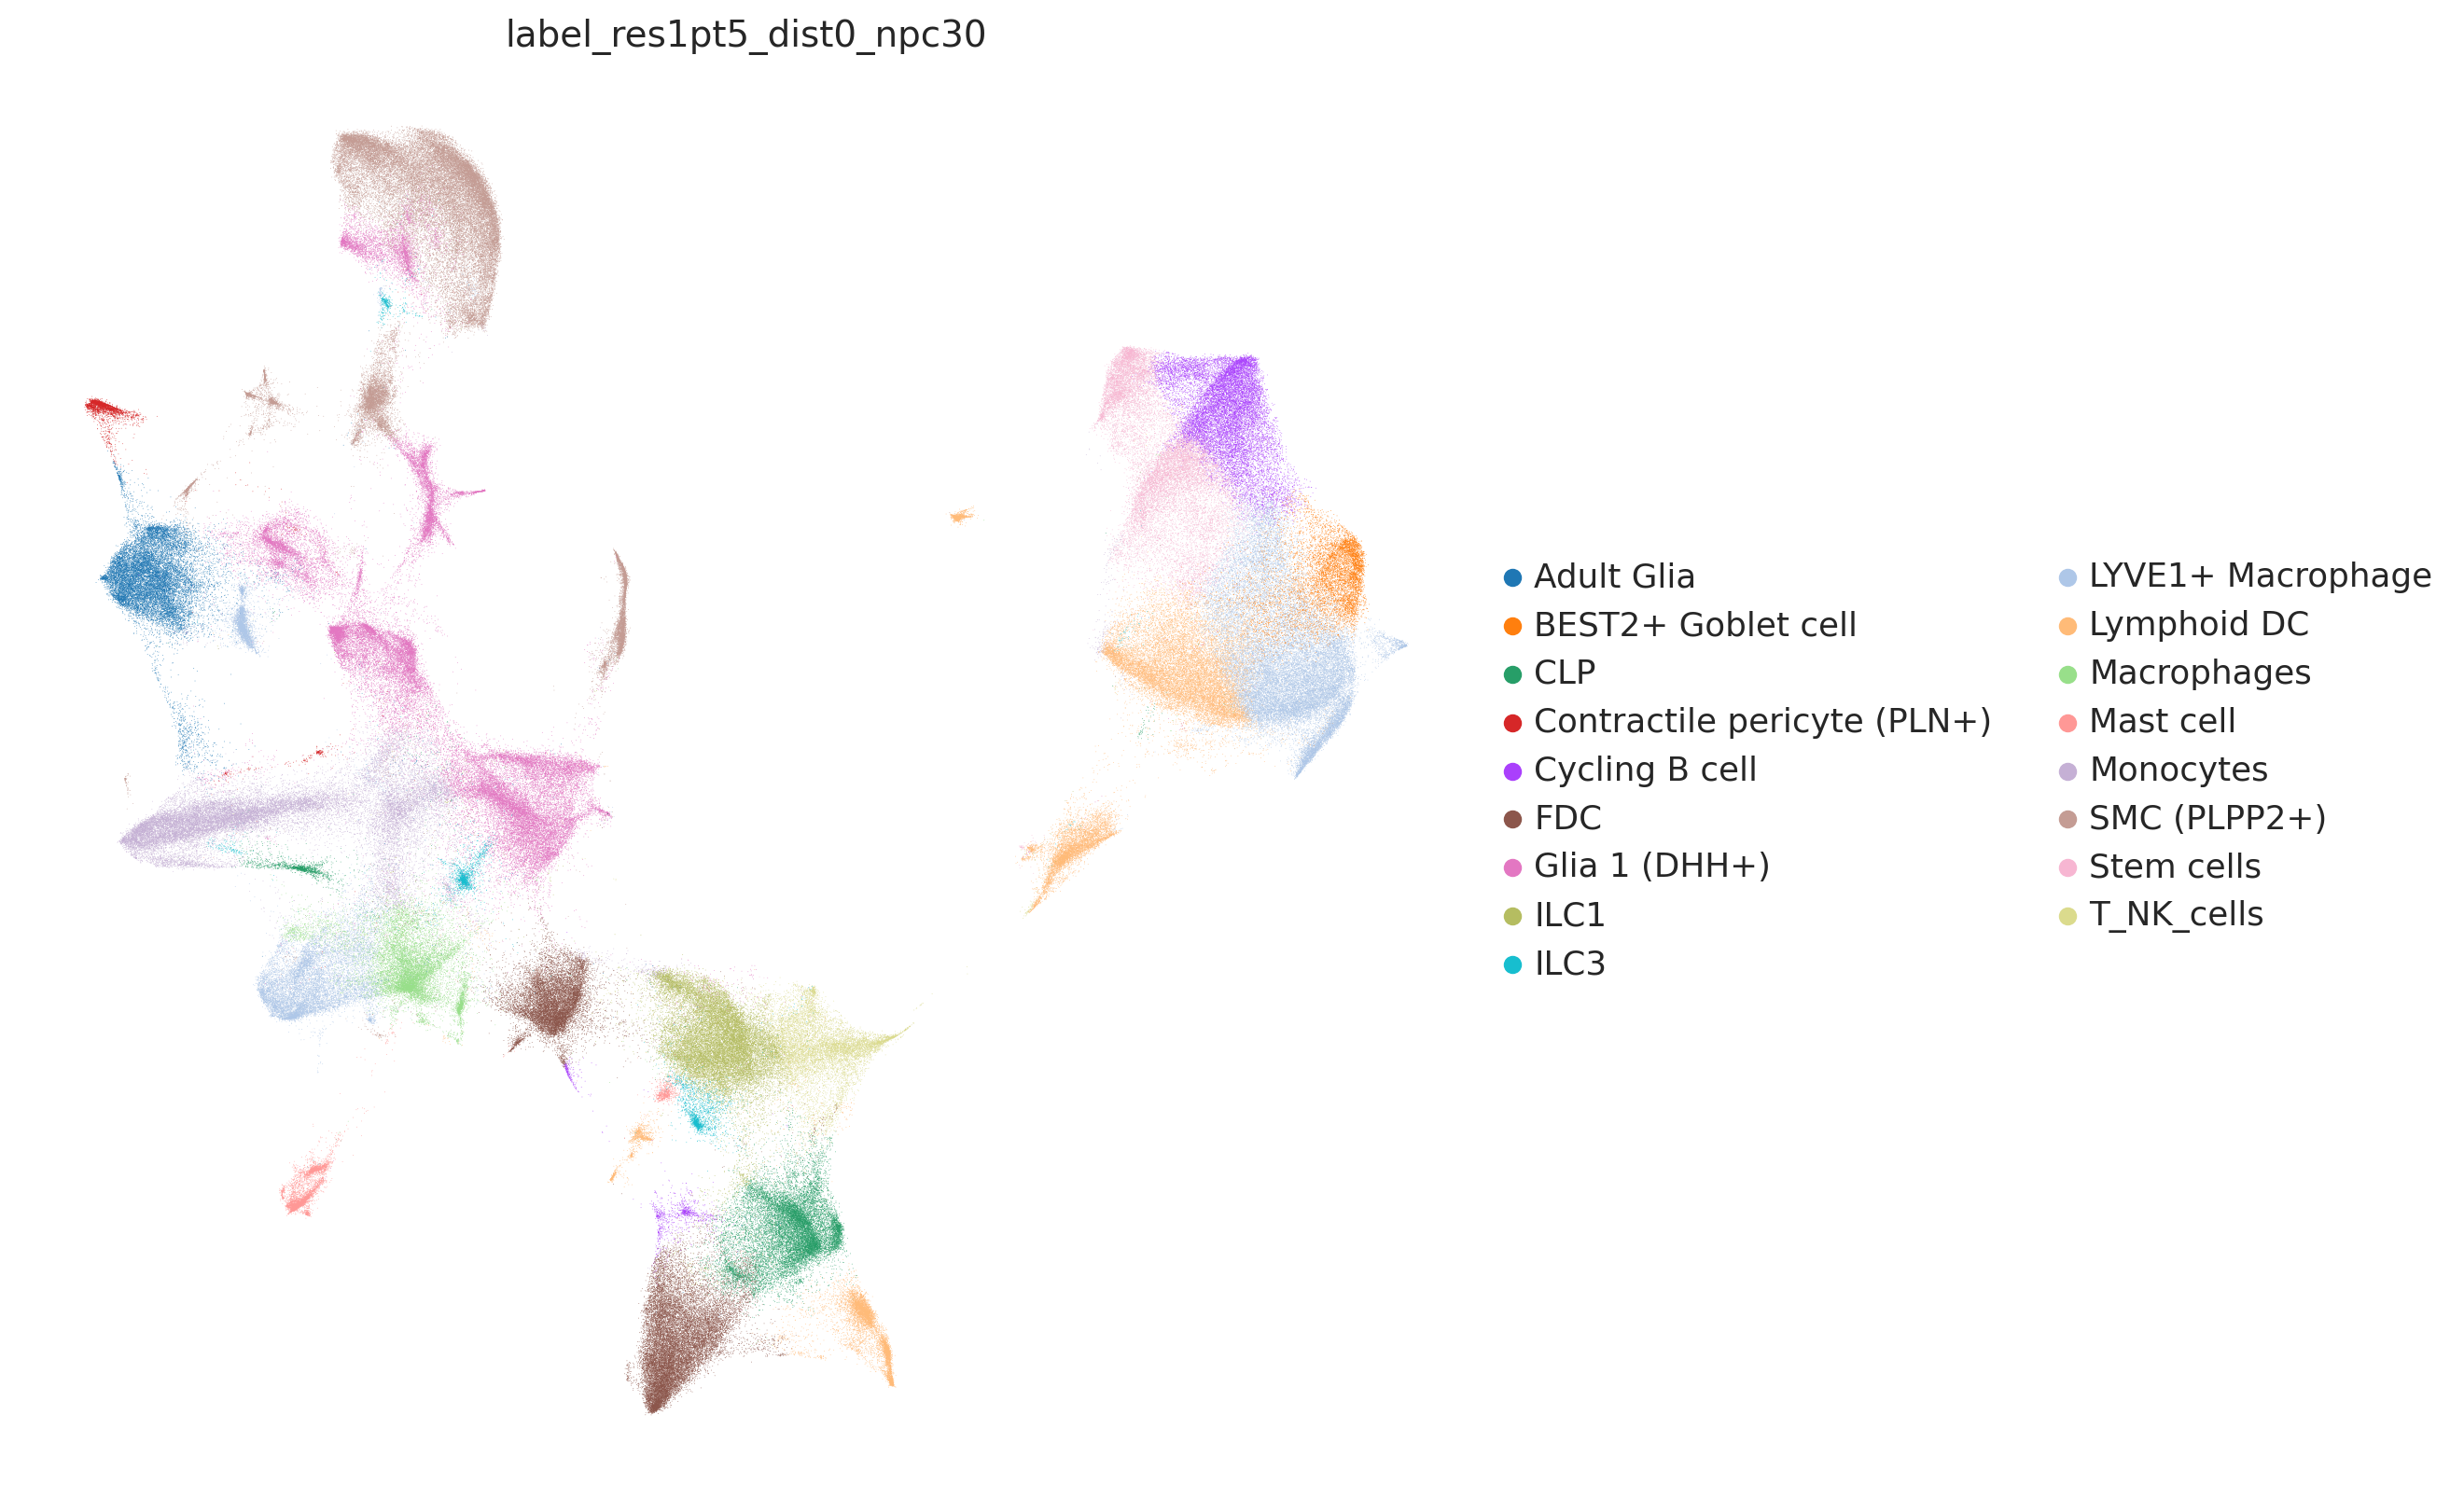

Markers File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Uninflamed-50336C___leiden_res1pt5_dist0_npc30_markers.csv
Clusters File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Uninflamed-50336C___leiden_res1pt5_dist0_npc30.csv


Markers File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Uninflamed-50336C___label_res1pt5_dist0_npc30_markers.csv
Clusters File: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Uninflamed-50336C___label_res1pt5_dist0_npc30.csv


AnnData object with n_obs × n_vars = 563427 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID

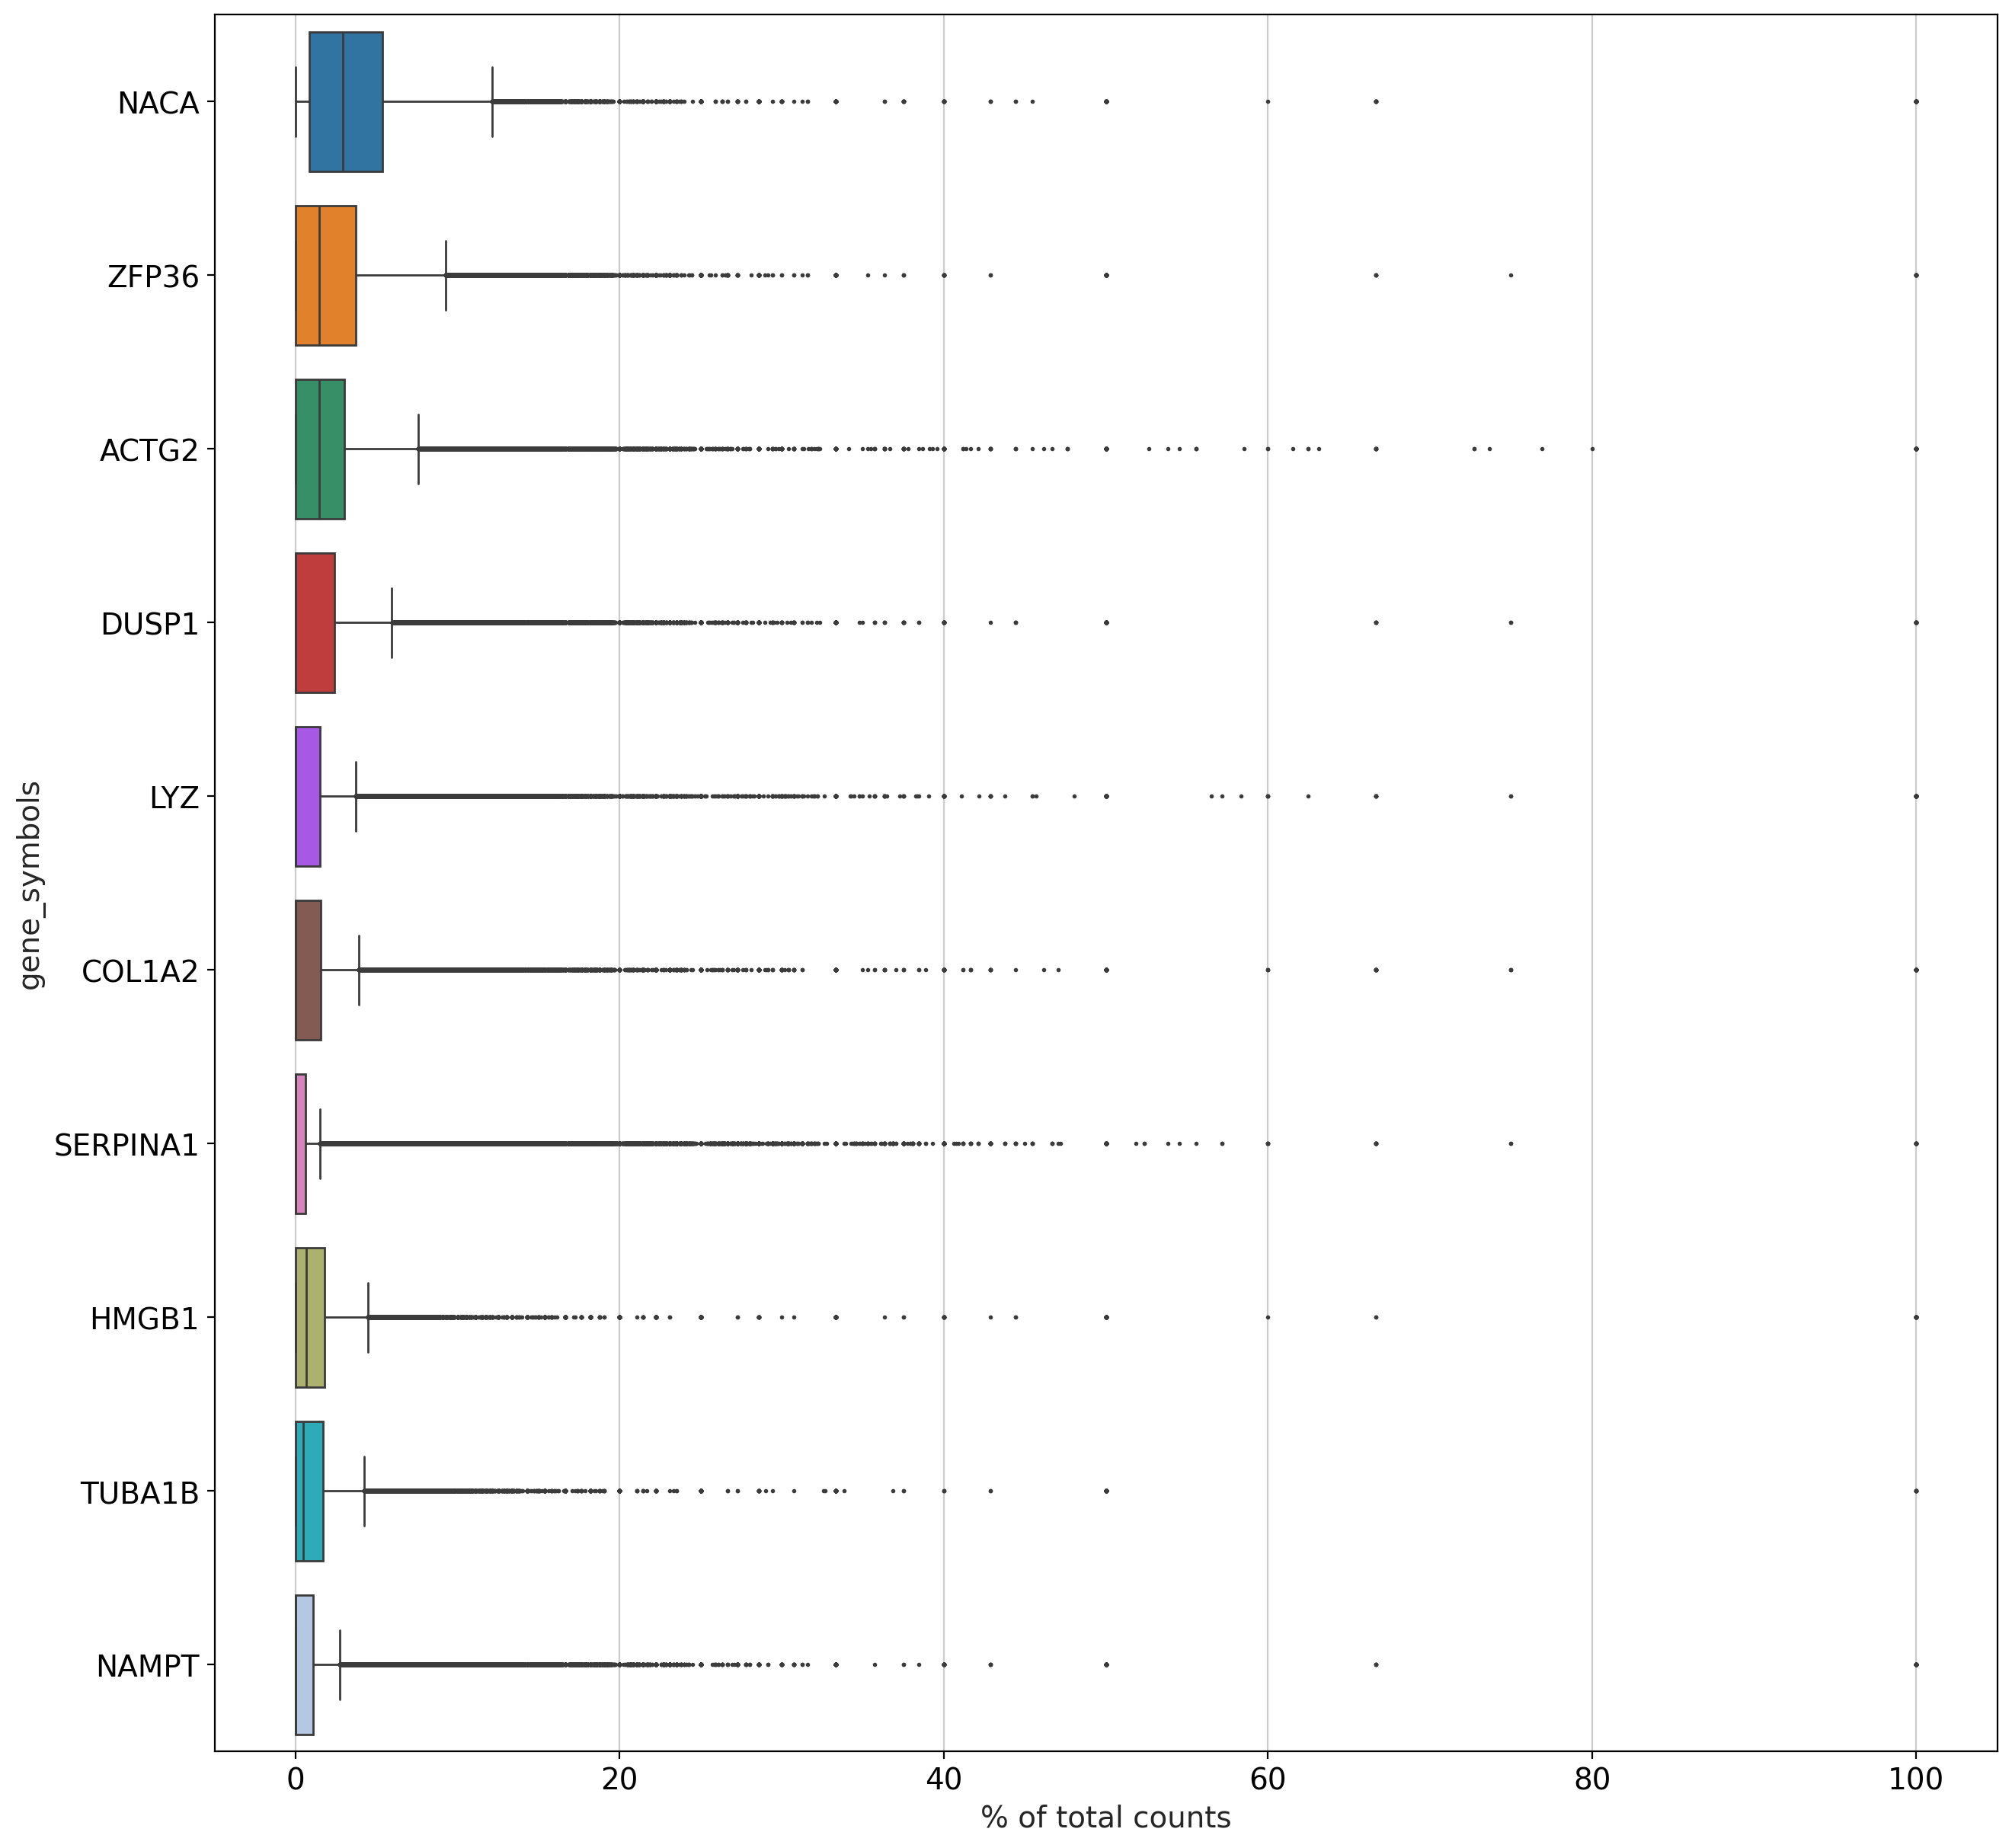

dsfasfda AnnData object with n_obs × n_vars = 563427 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'


Cell Counts: Initial


Observations: 563427



Gene Counts: Initial

Em

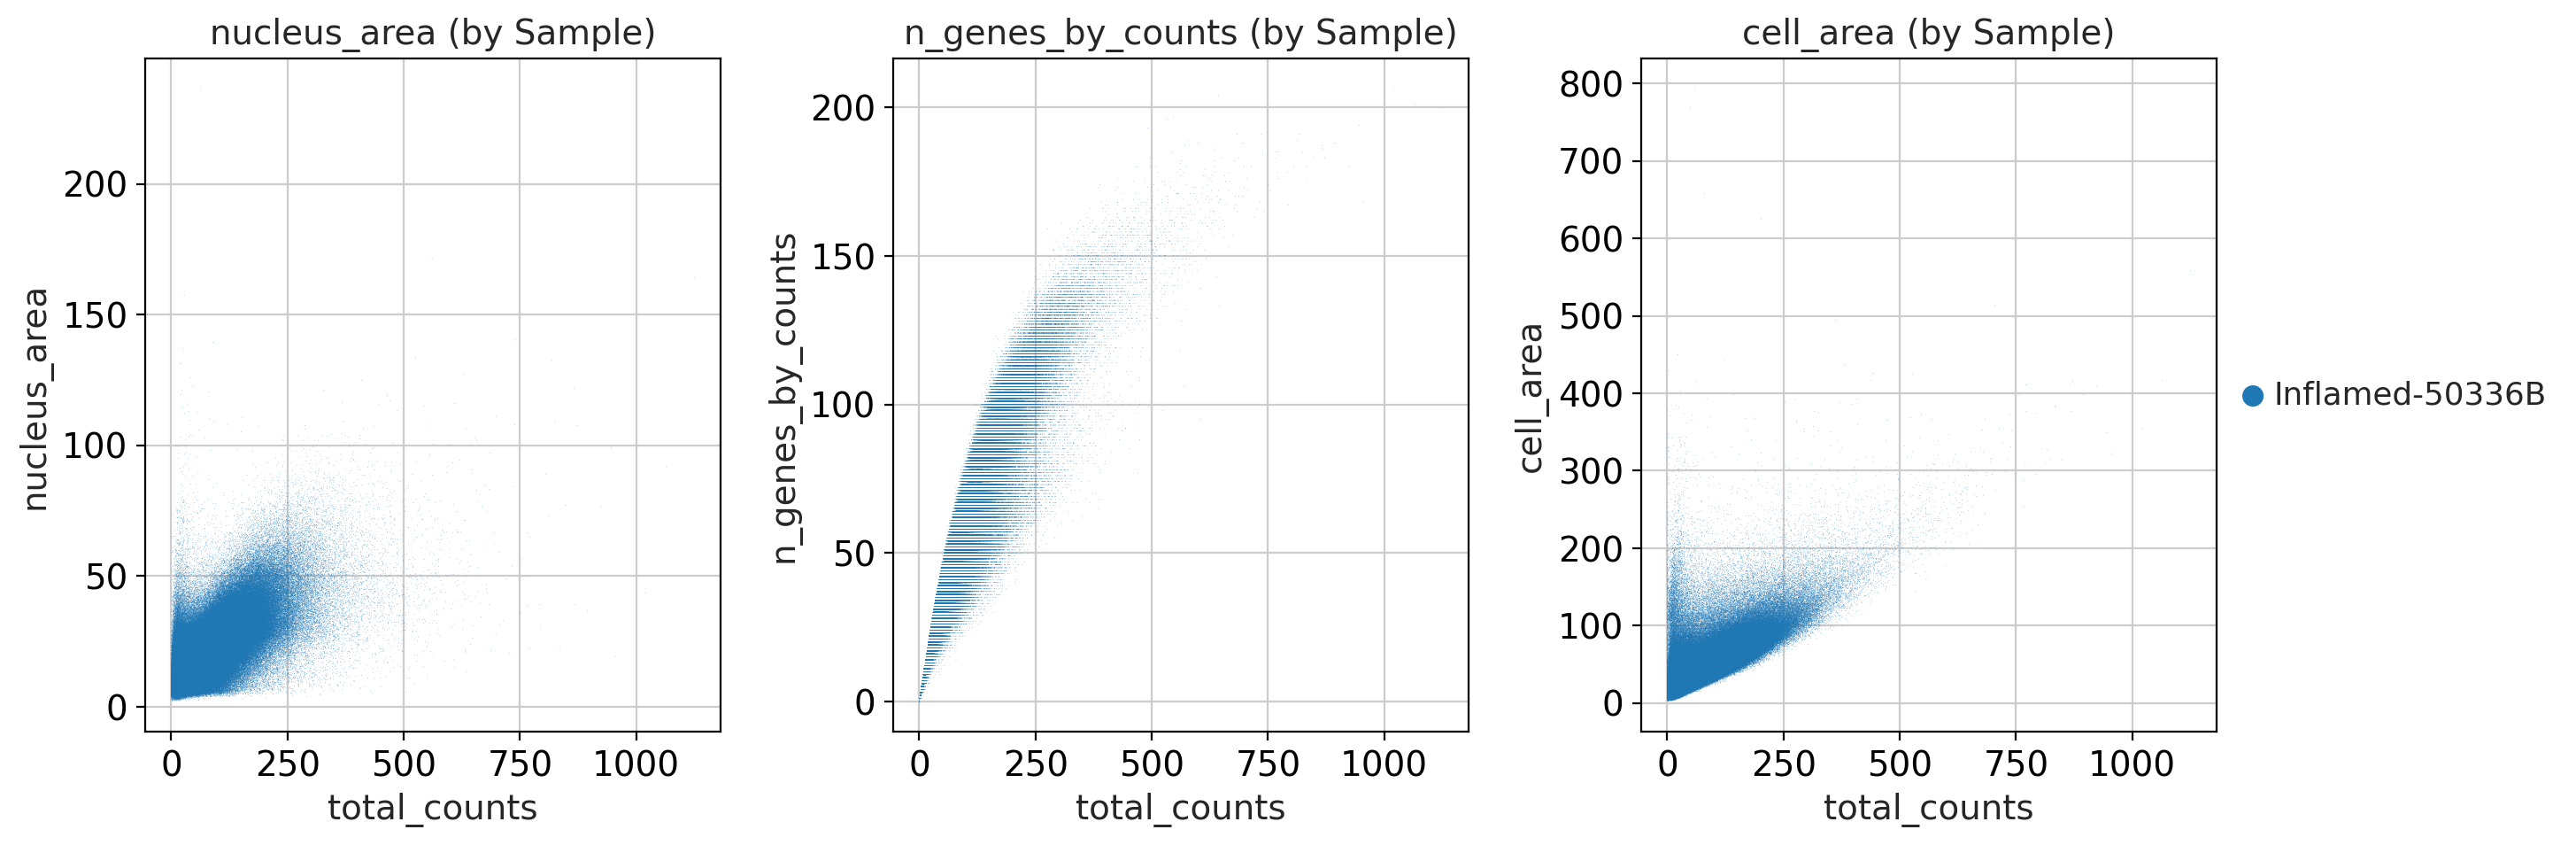


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>
dsfasfda AnnData object with n_obs × n_vars = 559820 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_c

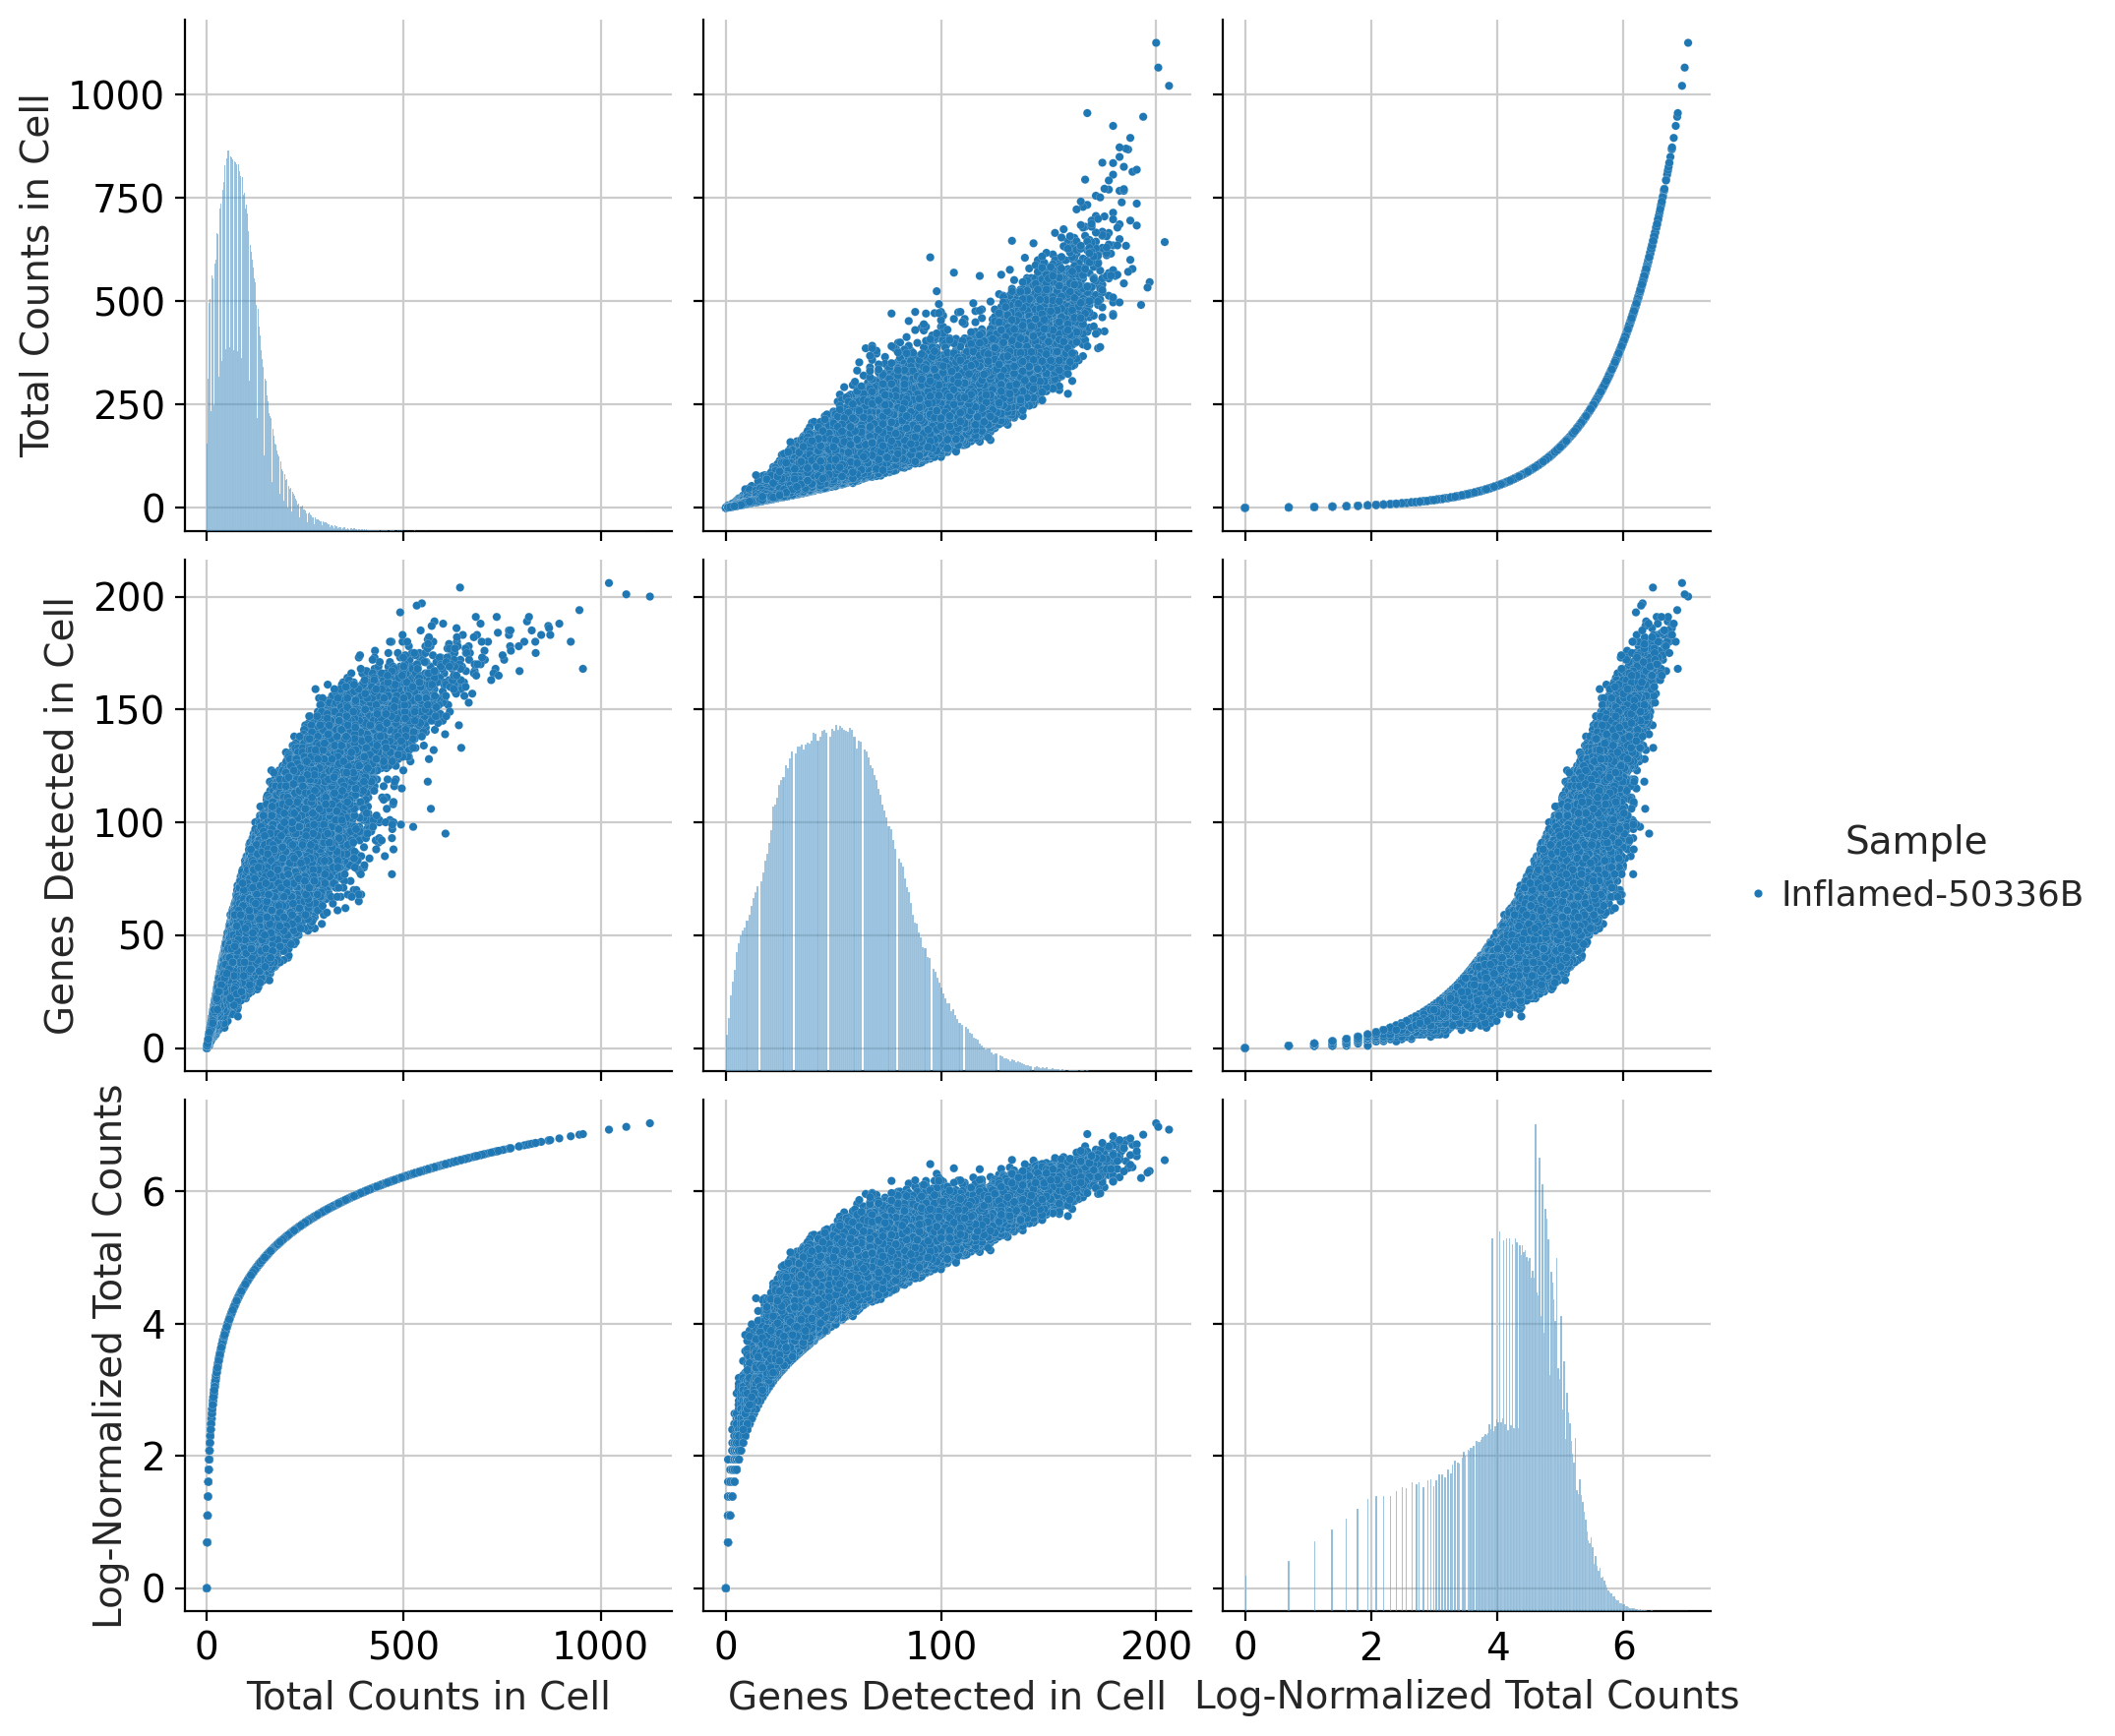

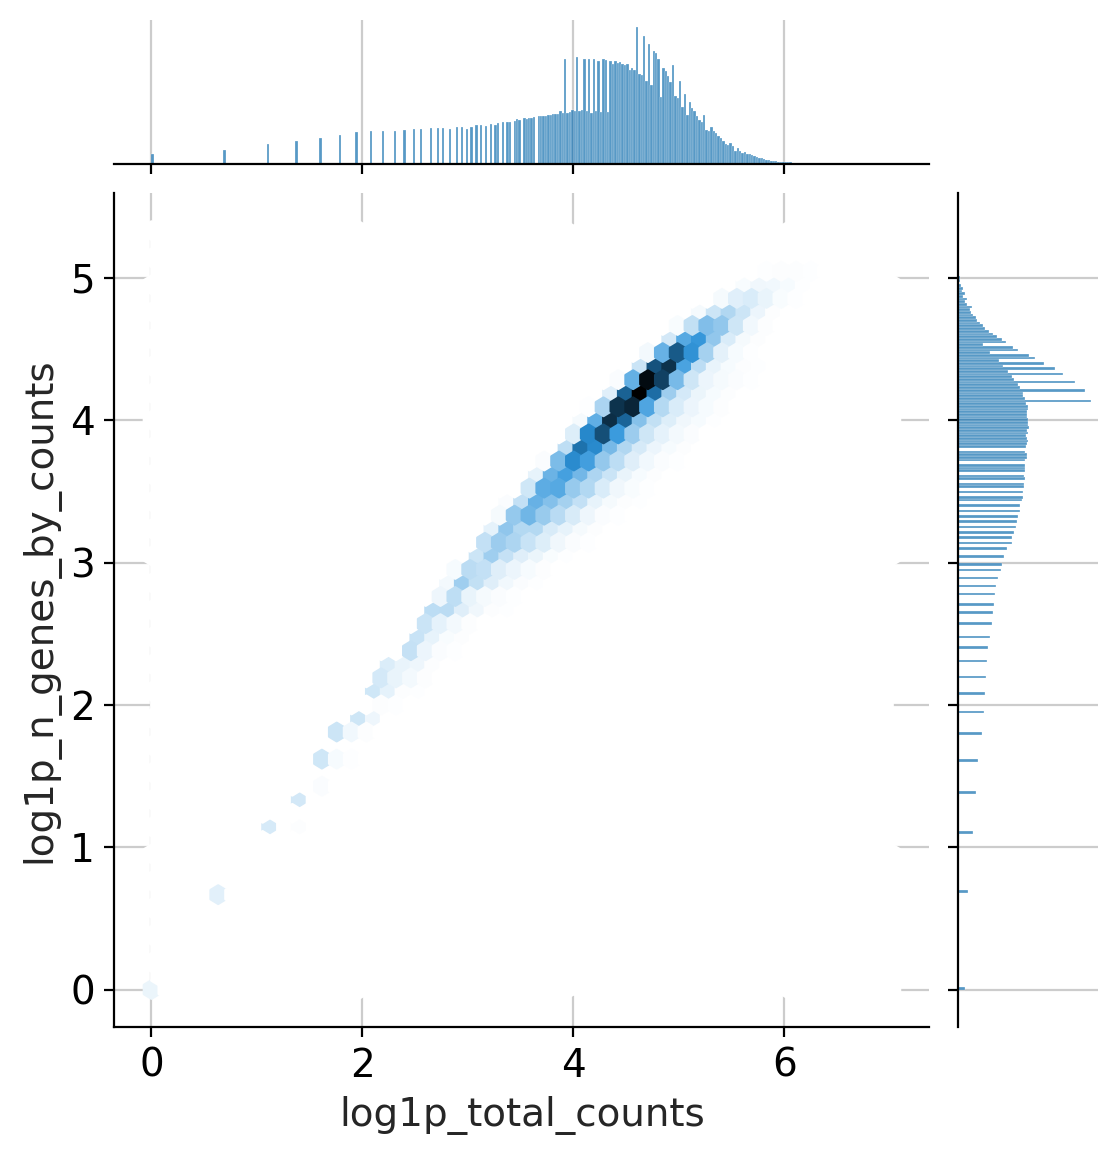

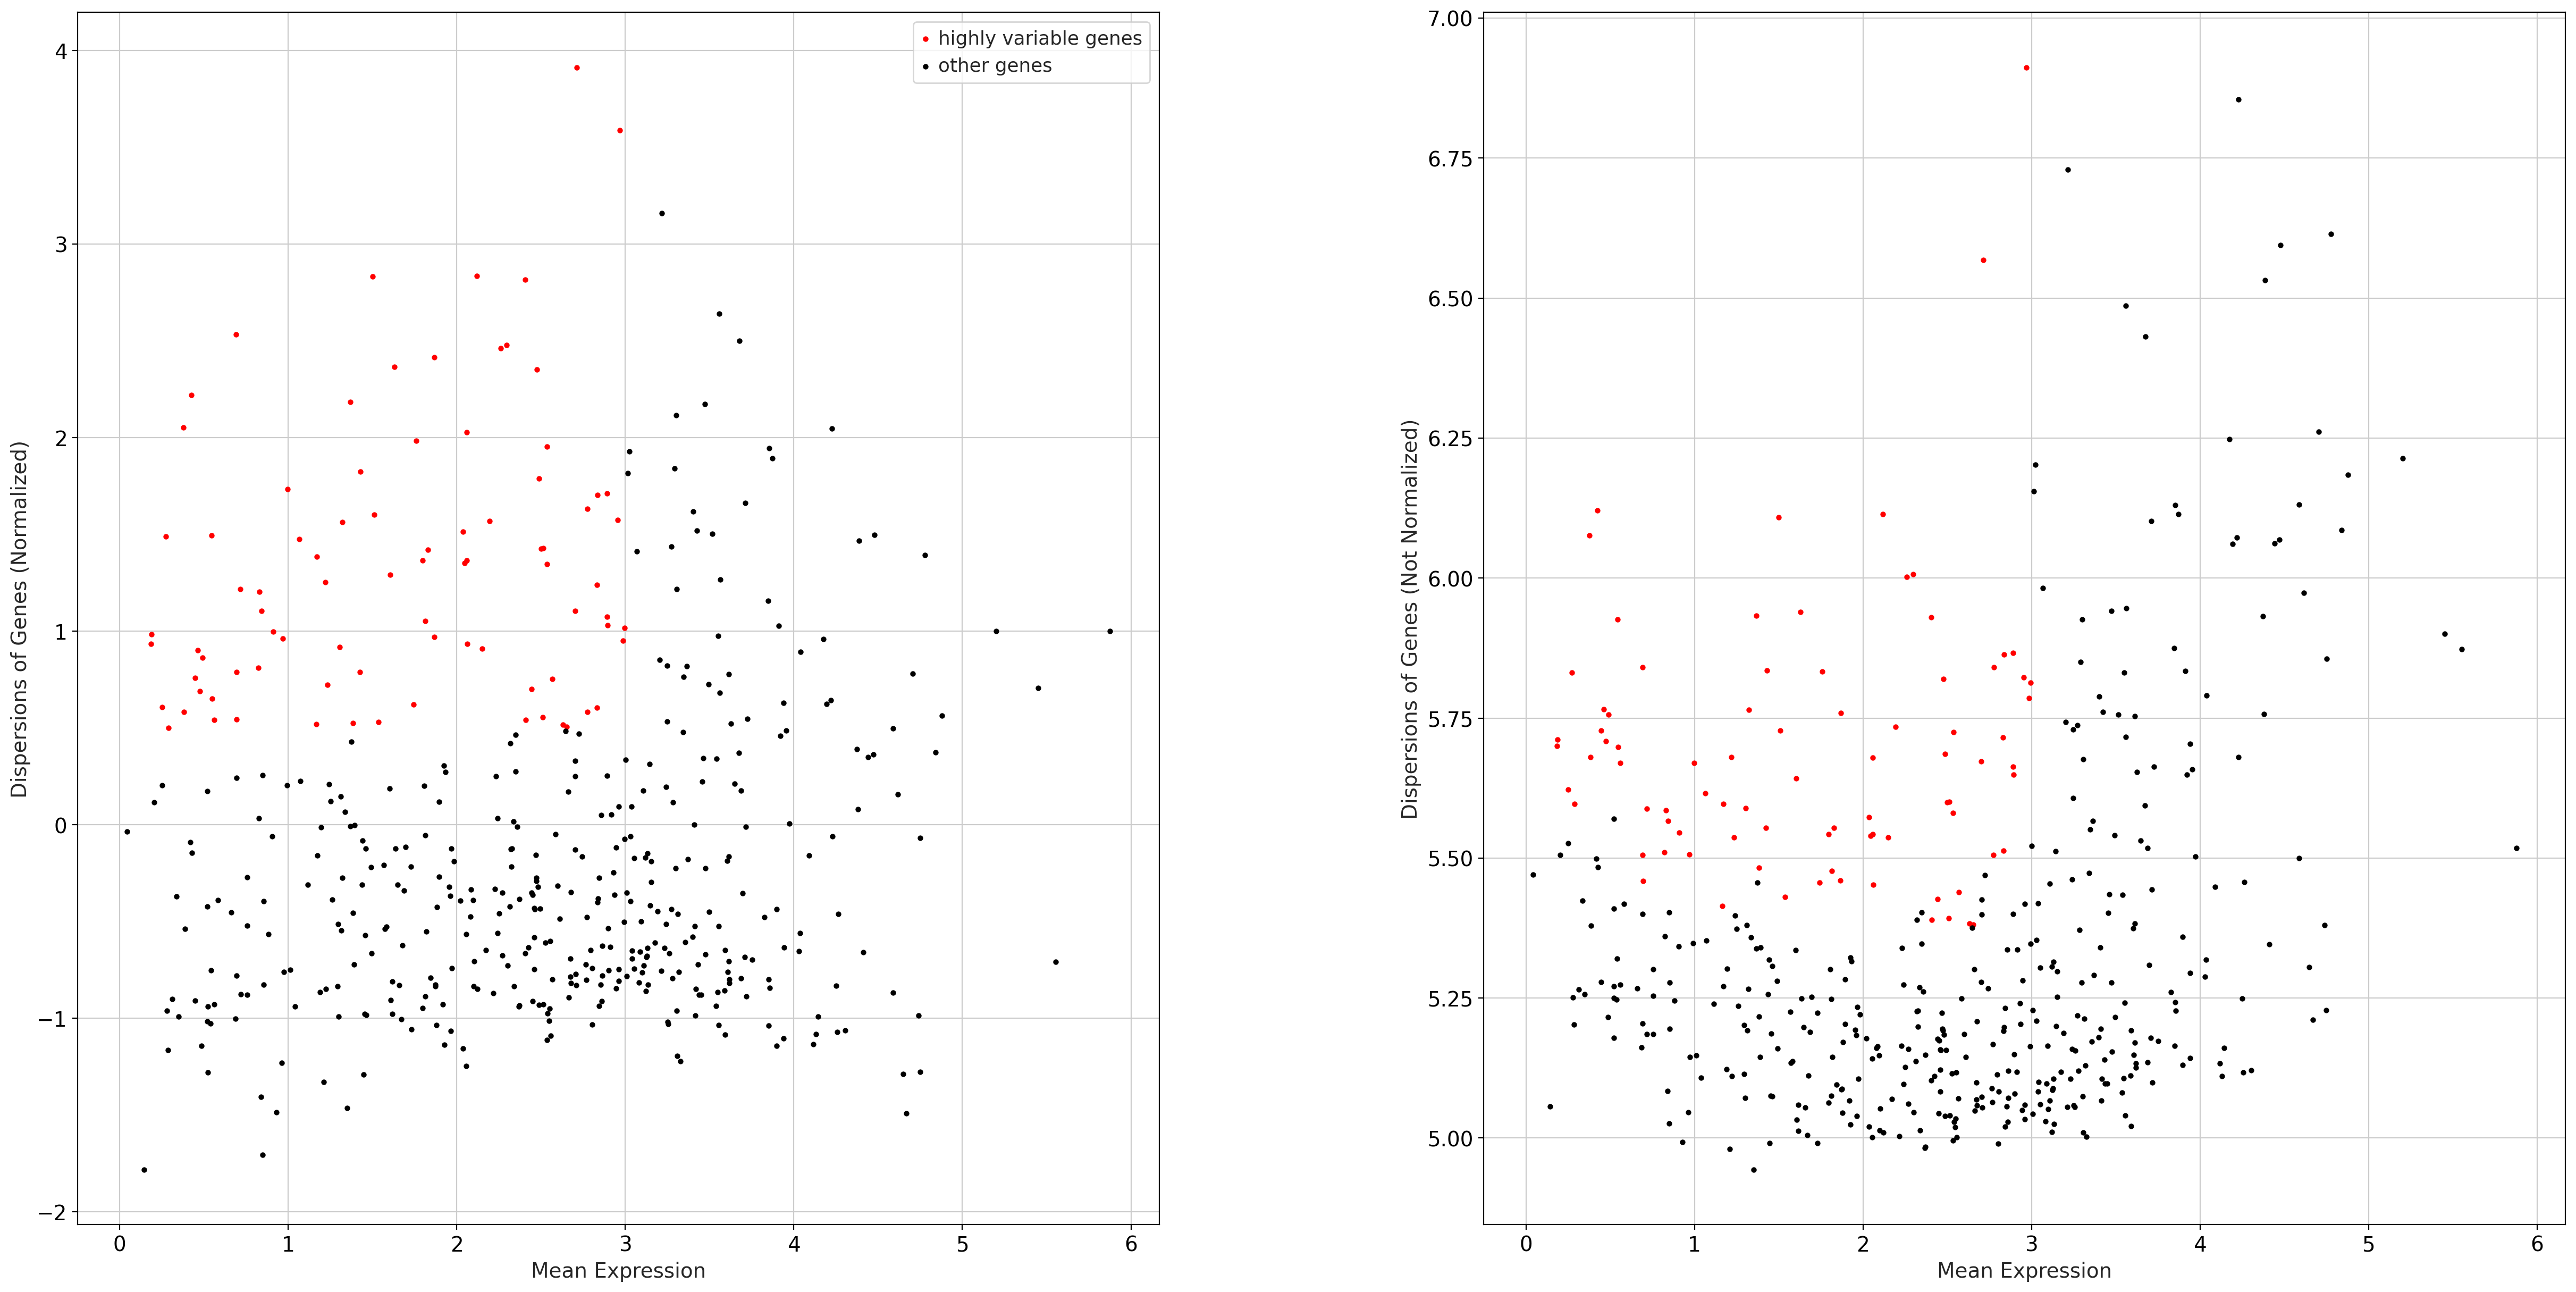


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...
dsfasfda AnnData object with n_obs × n_vars = 530116 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'out_file', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_c

In [5]:
%%time

print("\n\n", kws_pp, "\n\n")
for i, s in enumerate(selves):
    f_o = str(selves[i].rna.obs.out_file.iloc[0])

    # Preprocessing
    if load is False:
        _ = s.preprocess(**kws_pp, figsize=(15, 15))  # preprocess

    # Clustering at Different Resolutions & Minimum Distances
    for j, x in enumerate(kws_clustering):

        if j != 2:
            continue

        # Variables & Output Files
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        cct, cca = f"leiden_{x}", f"label_{x}"  # Leiden & annotation columns
        annot = assign[[col_assignment[j]]]  # gene-annotation dictionary

        # Clustering, Markers, Annotation, & Writing Output
        if load is False:
            _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
        if load is False or f"rank_genes_groups_{cct}" not in s.rna.uns:
            _ = s.find_markers(col_cell_type=cct, kws_plot=False)  # DEGs
        if reannotate is True or load is False:  # annotate; Explorer files
            _ = s.annotate_clusters(annot, col_cell_type=cct,
                                    col_annotation=cca)  # annotate
            for c in [k for k in [cct, cca] if k in s.rna.obs]:  # Explorer
                s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
                                 file_prefix=f"{s._library_id}__", n_top=True)

        # Write Final Object
        if load is False or reannotate is True and f_o is not None:
            s.write(f_o)

## Tangram Imputation

In [ ]:
%%time

if file_sc is not None:
    adata_sc = sc.read(file_sc)  # read whole tx'ome data for imputation
    if load is False:
        for i, s in enumerate(selves):
            out = s.impute(
                adata_sc.copy(), col_cell_type=col_cell_type_sc,
                mode="clusters", markers=None, plot=False, plot_density=False,
                plot_genes=None, col_annotation=col_tangram, out_file=None)
            out[0].write_h5ad(os.path.splitext(selves[
                0].rna.obs.out_file.iloc[0])[0] + "___tangram.h5ad")  # write
            s.write(s.rna.obs.out_file.iloc[0])
            s.write_clusters(out_dir, file_prefix=f"{s._library_id}___",
                             col_cell_type=col_tangram,
                             overwrite=True, n_top=True)
    s.plot_spatial(color=col_tangram)

## Plot Clusters

In [ ]:
for s in selves:
    s.plot_spatial(color=col_tangram)
    for j, x in enumerate(kws_clustering):
        _ = s.plot_spatial(color=[f"leiden_{x}",, f"label_{x}"])

## ToppGene

In [102]:
self = selves[1]

srcs = ["Cells of the human intestinal tract mapped across space and time",
        "Human Ileal Epithelial cells from Crohn’s Disease",
        "Human Ileal Immune cells from Crohn’s Disease"]
# cct = "leiden_res0pt5_dist0pt5_npc30"
# cct = "leiden_res0pt75_dist0pt3_npc30"
c_t = "leiden_res1pt5_dist0_npc30"

tgdf, mks = self.annotate_clusters(
        None, sources=srcs, col_cell_type=c_t, max_results=10000,
        name_pattern={srcs[0]: "SmallIntestine"}, p_threshold=1e-15,
        n_top_genes=20, n_top_annotations=20)
tgdf.loc[:, "Name"] = tgdf.Name.str.strip(
        " / Per Region, Age_group, Lineage, cell class, cell type   ").apply(
                lambda x: re.sub("SmallIntestine", "SmInt", " --- ".join(
                        x.split("|")[0].split("-"))))

IndexError: list index out of range

In [ ]:
s = self
s._library_id

In [86]:
clus = "0"

print(mks.loc[clus].index.values, "\n\n")
print(assign.loc[mks.loc[clus].index.intersection(assign.index)].iloc[
    :, [0]].rename_axis("Gene").reset_index().groupby("group").apply(
        lambda x: ", ".join(x.Gene.unique())))
print(tgdf.loc[clus].iloc[:, :-3])
mks_grps = assign.loc[mks.loc[clus].index.intersection(
    assign.index)].iloc[:, [0]].rename_axis("Gene")
percs_exp = mks_grps.groupby("Gene").apply(lambda x: 100 * np.mean(s.rna[
    s.rna.obs[r] == clus][:, x.name].X > 0))
percs_exp = assign.loc[mks.loc[clus].index.intersection(
    assign.index)].iloc[:, [0]].rename_axis("Gene").iloc[
        :, 0].str.get_dummies(',').groupby("Gene").max().groupby(
            "Gene").apply(lambda g: g.replace(
                1, percs_exp.loc[g.name])).replace(0, "")
percs_exp.applymap(lambda x: x if x == "" else str(int(x)))

['DES' 'MYH11' 'FLNA' 'ACTA2' 'CSRP1' 'TAGLN' 'ACTG2' 'KIT' 'CNN1' 'MYLK'
 'PLN' 'GREM1' 'RGS5' 'ENAH' 'COL1A1' 'NPNT' 'COL4A2' 'PDLIM7' 'IGFBP7'
 'LPP'] 


group
Adult Glia                                                  IGFBP7
CLDN10+ cells                                               IGFBP7
CX3CR1+ CD8 Tmem                                              FLNA
Contractile pericyte (PLN+)                                    PLN
Distal progenitor                                             FLNA
Glia 1 (DHH+)                                       COL1A1, COL4A2
ICC                                                            KIT
ILC3                                                           KIT
ILCP                                                        IGFBP7
LZ GC cell                                                     LPP
Mast cell                                                      KIT
Megakaryocyte                                               PDLIM7
Mesenchymal                      

Adult Glia CLDN10+ cells CX3CR1+ CD8 Tmem  \
Gene   Gene                                               
ACTA2  ACTA2                                              
ACTG2  ACTG2                                              
CNN1   CNN1                                               
COL1A1 COL1A1                                             
COL4A2 COL4A2                                             
DES    DES                                                
ENAH   ENAH                                               
FLNA   FLNA                                          97   
GREM1  GREM1                                              
IGFBP7 IGFBP7         57            57                    
KIT    KIT                                                
LPP    LPP                                                
MYH11  MYH11                                              
MYLK   MYLK                                               
NPNT   NPNT                                               
PDLIM7 PDLIM7                                             
PLN    PLN                                                
RGS5   RGS5                                               

              Contractile pericyte (PLN+) Distal progenitor Glia 1 (DHH+) ICC  \
Gene   Gene                                                                     
ACTA2  ACTA2                                                                    
ACTG2  ACTG2                                                                    
CNN1   CNN1                                                                     
COL1A1 COL1A1                                                          73       
COL4A2 COL4A2                                                          66       
DES    DES                                                                      
ENAH   ENAH                                                                     
FLNA   FLNA                                              97                     
GREM1  GREM1                                                                    
IGFBP7 IGFBP7                                                                   
KIT    KIT                                                                 71   
LPP    LPP                                                                      
MYH11  MYH11                                                                    
MYLK   MYLK                                                                     
NPNT   NPNT                                                                     
PDLIM7 PDLIM7                                                                   
PLN    PLN                             75                                       
RGS5   RGS5                                                                     

              ILC3 ILCP LZ GC cell Mast cell Megakaryocyte Mesenchymal Neural  \
Gene   Gene                                                                     
ACTA2  ACTA2                                                                    
ACTG2  ACTG2                                                                    
CNN1   CNN1                                                                     
COL1A1 COL1A1                                                              73   
COL4A2 COL4A2                                                                   
DES    DES                                                                      
ENAH   ENAH                                                                     
FLNA   FLNA                                                                     
GREM1  GREM1                                                                    
IGFBP7 IGFBP7        57                                                    57   
KIT    KIT      71                        71                                    
LPP    LPP                      45                                              
MYH11  MYH11                                                                  

# Analyze

## Centrality Scores

In [ ]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Spatial Clustering

In [ ]:
for s in selves:
    cct = f"leiden_spatial_{list(kws_clustering.keys())[-1]}"
    _ = s.cluster_spatial(key_added=cct,
                          **kws_clustering[list(kws_clustering.keys())[-1]])
    _ = s.find_markers(col_cell_type=cct, kws_plot=False)
    _ = s.annotate_clusters(assign[[col_assignment[-1]]], col_cell_type=cct,
                            col_annotation=f"annotation_{cct}")
    for c in [cct, f"annotation_{cct}"]:
        s.plot_spatial(c)
        if out_dir is not None:
            s.write_clusters(out_dir, col_cell_type=c,
                             n_top=True, overwrite=True,
                             file_prefix=f"{s._library_id}___")
    if out_dir is not None:
        s.write(str(s.rna.obs.out_file.iloc[0]))

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=15, method="moran", n_perms=10, **kws)

## Receptor-Ligand Interactions

In [ ]:
%%time

for s in selves:
    kss, ktt = None, None
    _ = s.calculate_receptor_ligand(
        col_condition=False, p_threshold=0.01, remove_ns=True,
        figsize=(30, 20), top_n=25, key_sources=kss, key_targets=ktt)
    # s.calculate_receptor_ligand_spatial()

## Cell Type Composition 

In [ ]:
for s in selves:
    s.run_composition_analysis()

## GEX

In [ ]:
for s in selves:
    s.plot_spatial(color=["TNF", "IL23", col_cell_type])

In [ ]:
_ = self.calculate_spatial_distance("LTi-like NCR+ ILC3", genes="CSF2RB")

In [ ]:
adata.X = adata.layers["counts"]
sq.tl.var_by_distance(
    adata, "LTi-like NCR+ ILC3", col_cell_type, library_key=col_sample_id,
    design_matrix_key="design_matrix", covariates=["Patient", "Inflamed"],
    metric="euclidean", spatial_key=self._spatial_key, copy=False)
sq.pl.var_by_distance(
    adata=adata, var=["CSF2RB", "CSF2RA", "IL7R"],
    anchor_key="LTi-like NCR+ ILC3",
    covariate="Inflamed")

# Workspace

## Manual Annotations

### Uninflamed-50452A

In [ ]:
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
s.get_layer("counts", inplace=True)
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "9"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "9"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][
    :, "ADAMDEC1"].X > 0))

In [ ]:
for x in ["COL1A1", "PEG10", "RCN3"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "10"][:, x].X > 0))

In [ ]:
for x in ["BMP5", "F3", "MMP11", "CCL8", "NPY", "CH25H"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "15"][:, x].X > 0))

In [ ]:
for x in ["LGR5"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "16"][:, x].X > 0))

In [ ]:
for x in ["CRIP2", "KCNA5", "LBH", "NET1", "PLN", "RERGL"]:
    print(round(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "20"][:, x].X > 0) * 100, 0))

In [ ]:
for x in ["TPSAB1", "CMA1"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "21"][:, x].X > 0))

In [ ]:
for x in ["GNLY", "GZMB"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] != "23"][:, x].X > 0))

In [ ]:
for x in marker_genes_dict["Pericyte"]:
    print(int(100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "25"][
        :, x].X > 0)), " vs. ", int(100 * np.mean(s.rna[s.rna.obs[
            f"leiden_{r}"] != "25"][:, x].X > 0)))

In [ ]:
comp = "2"
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == "11"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == comp][
            :, x].X > 0))) + "%" for x in ["COL4A1", "COL4A2", "DLC1"]]))
print(f"\n...compared to {comp}")

In [ ]:
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == "9"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] != "9"][
            :, x].X > 0))) + "%" for x in [
                "ZBTB38", "IFNAR2", "SELENOM", "XBP1"]]))

### Stricture-50452C

In [ ]:
# Memory B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
r = "leiden_res0.75_dist0.3_npc30"
s.rna.obs.loc[:, f"leiden_{r}"] = s.rna.obs[
    f"leiden_{r}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "GPR183", "HHEX", "INPP5D", "LRRK2"]]))
print(f"\n...compared to {comp}")

In [ ]:
# Naive B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
r = "leiden_res0.75_dist0.3_npc30"
s.rna.obs.loc[:, f"leiden_{r}"] = s.rna.obs[
    f"leiden_{r}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "IRF1", "LNPEP", "PLAC8", "IFITM1"]]))
print(f"\n...compared to {comp}")

### Uninflamed-50006B

In [ ]:
# Neural-Glia
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "24"
comp = ["19"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Neural"].index.intersection(
                s.rna.var_names).difference(assign[
                    assign.Bin == "Glia"].index)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Epithelial
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "26"
# comp = ["10", "28"]
# comp = ["1", "3", "4", "7", "8", "10", "20", "26"]
# comp = ["3", "4", "7", "8", "10", "26"]
comp = ["4", "7", "8", "9"]  # suspected goblets
# comp = ["8"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in [
            "MUC2", "MUC4", "MUC1", "KLK1", "ZG16",  # "FAM3D",
            "BEST2", "BEST4","LGR5", "CDCA7", "CCL20", "LYZ",
            "HCK", "MATK", "ZFHX3"]])  # Tuft markers
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Eptithelial
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "26"
comp = ["10", "28"]
# comp = ["1", "3", "4", "7", "8", "10", "20", "26"]
# comp = ["3", "4", "7", "8", "10", "26"]
# comp = ["4", "7", "8", "9"]  # suspected goblets
# comp = ["8"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in [
            "MUC5B", "KIT", "MARCKSL1", "NACA", "FAM3D", "LCN2", "IRF2BP2",
            "MUC4", "SATB2", "UQCRC1", "SLC39A8", "SERBP1", "TP53", "MYO10",
            "KLK1", "HMGB1", "HOXA3", "NR5A2", "CAT", "LIMA1", "COX8A",
            "LGALS9", "HMGB2", "CDCA7", "ZFP91", "MUC1", "ATF6B"]])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
ggc = ["HCK", "MATK", "ZFHX3"]
subs = s.rna[s.rna.obs[r] == clus].copy()
subs = sc.tl.score_genes(subs, ggc, score_name="|".join(ggc),
                         use_raw=False, copy=True)  # score co-GEX
np.mean(subs.obs["|".join(ggc)] > 0)

### Stricture-50006C

In [61]:
# Stricture-50006C
# T Cell
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "22"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "T Cell"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"22 compared to ['3', '23', '11', '17', '27', '28', '2', '6', '7', '12', '4', '8', '14', '5', '25', '20', '16', '18', '19', '1', '26', '15', '0', '10', '13', '9', '29', '24', '21']: GPR183: 4 vs. 10%, SOCS3: 4 vs. 2%, CH25H: 3 vs. 2%, GZMK: 0 vs. 1%, FLNA: 69 vs. 38%, TBX21: 0 vs. 0%, GNLY: 0 vs. 1%, IFNGR1: 30 vs. 35%, KLRC1: 0 vs. 1%, TYROBP: 1 vs. 4%, CMC1: 2 vs. 3%, FCER1G: 6 vs. 12%, MATK: 0 vs. 1%, NKG7: 0 vs. 1%, IRF8: 4 vs. 14%, S100B: 4 vs. 4%, SERPINF1: 27 vs. 15%, CD79A: 3 vs. 9%, BACH2: 2 vs. 2%, IKZF3: 1 vs. 4%, ZBTB38: 26 vs. 37%, LNPEP: 24 vs. 31%, CREM: 11 vs. 11%, CDKN1A: 49 vs. 29%, PIM1: 5 vs. 14%, TUBA1B: 66 vs. 68%, FOSL2: 38 vs. 37%, HSPA1A: 46 vs. 38%, IGFBP3: 24 vs. 10%, STIP1: 14 vs. 18%, HMGB2: 28 vs. 34%, GZMB: 0 vs. 1%, CD3D: 0 vs. 2%, CD3E: 0 vs. 5%, CD4: 15 vs. 10%"

In [75]:
# Stricture-50006C
# gDT
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group.apply(lambda x: "gdT" in x)
            ].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"27 compared to ['3', '23', '11', '17', '28', '2', '6', '7', '12', '4', '8', '14', '5', '25', '20', '16', '22', '18', '19', '1', '26', '15', '0', '10', '13', '9', '29', '24', '21']: IKZF3: 20 vs. 4%, ZBTB38: 24 vs. 37%, LNPEP: 25 vs. 30%, CREM: 18 vs. 11%, CDKN1A: 16 vs. 30%, PIM1: 10 vs. 14%, TUBA1B: 53 vs. 68%, FOSL2: 32 vs. 37%, HSPA1A: 20 vs. 38%, IGFBP3: 7 vs. 10%, STIP1: 9 vs. 18%, HMGB2: 31 vs. 34%"

In [124]:
# Stricture-50006C
# LEC
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group.apply(lambda x: "LEC" in x)
            ].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"27 compared to ['11', '17', '6', '7', '4', '20', '22', '32', '18', '19', '1', '15', '31', '13', '10', '29', '3', '23', '28', '30', '2', '12', '8', '14', '5', '25', '26', '0', '16', '9', '24', '21']: SELENOM: 7 vs. 11%, IL34: 3 vs. 2%, OAS1: 14 vs. 13%, MAN1A1: 67 vs. 27%, TSPO: 2 vs. 1%, ADM: 12 vs. 8%, MT1E: 2 vs. 9%, CEBPB: 18 vs. 25%"

In [93]:
# Stricture-50006C
# cDC
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "25"
# comp = list(s.rna.obs[r].unique())
comp = ["6"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group == "cDC1"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"25 compared to ['6']: NAMPT: 48 vs. 60%, IL1B: 4 vs. 4%, PLAUR: 6 vs. 10%, SOCS3: 1 vs. 0%, SERPINA1: 36 vs. 71%, CXCL8: 5 vs. 3%, CD52: 17 vs. 20%, TNIP3: 3 vs. 1%, FOSL2: 11 vs. 17%, CD44: 32 vs. 30%"

In [107]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "21"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Neural"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"11 compared to ['4']: RNASE1: 81 vs. 7%, BCL2: 8 vs. 4%, UNC5B: 2 vs. 1%, LINC00682: 0 vs. 0%, RAMP1: 4 vs. 49%, SKAP2: 12 vs. 16%, IGFBP7: 24 vs. 62%, S100B: 14 vs. 9%, COL1A1: 37 vs. 86%, BCAN: 0 vs. 0%, TPD52L1: 1 vs. 3%"

In [122]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "11"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in ["LYVE1"]])
f"{clus} compared to {comp}: {ccc}"

"11 compared to ['17', '27', '6', '7', '4', '20', '22', '32', '18', '19', '1', '15', '31', '13', '10', '29', '3', '23', '28', '30', '2', '12', '8', '14', '5', '25', '26', '0', '16', '9', '24', '21']: LYVE1: 40 vs. 4%"

In [123]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Endothelial"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"27 compared to ['11', '17', '6', '7', '4', '20', '22', '32', '18', '19', '1', '15', '31', '13', '10', '29', '3', '23', '28', '30', '2', '12', '8', '14', '5', '25', '26', '0', '16', '9', '24', '21']: AQP1: 10 vs. 24%, UACA: 52 vs. 21%, MYO10: 6 vs. 12%, IGFBP3: 2 vs. 6%, EFCAB14: 33 vs. 25%, PRND: 0 vs. 0%, GPIHBP1: 2 vs. 0%, GJA4: 5 vs. 2%, UNC5B: 36 vs. 3%"

In [126]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "31"
comp = ["4"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Glia"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"22 compared to ['11', '17', '27', '6', '7', '4', '20', '32', '18', '19', '1', '15', '31', '13', '10', '29', '3', '23', '28', '30', '2', '12', '8', '14', '5', '25', '26', '0', '16', '9', '24', '21']: SOCS3: 0 vs. 2%, NKG7: 33 vs. 1%, GPR183: 38 vs. 17%, FCER1G: 62 vs. 23%, TYROBP: 18 vs. 6%, KLRC1: 53 vs. 0%, CMC1: 7 vs. 2%, GZMK: 29 vs. 3%, MATK: 31 vs. 0%"

### Uninflamed-50336C


In [46]:
# Stricture-50006C
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "9"
# comp = ["4"]
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group == "LYVE1+ Macrophage"].index.intersection(
                s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"9 compared to ['25', '2', '7', '8', '11', '12', '27', '22', '16', '13', '3', '6', '10', '23', '26', '20', '31', '19', '30', '1', '18', '5', '28', '24', '17', '21', '15', '4', '14', '29', '0']: RNASE1: 13 vs. 18%, LYVE1: 24 vs. 10%, FOLR2: 4 vs. 2%, DAB2: 34 vs. 15%, CD163: 78 vs. 14%, PLTP: 31 vs. 11%, CD14: 16 vs. 3%, MAF: 53 vs. 39%, MRC1: 67 vs. 12%, FCGRT: 71 vs. 39%, MAN1A1: 35 vs. 32%, METRNL: 13 vs. 10%, CCL2: 15 vs. 15%, RCN3: 16 vs. 8%"

In [21]:
# Stricture-50006C
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "0"
# comp = ["4"]
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bucket == "B Cell"].index.intersection(
                s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"0 compared to ['25', '2', '7', '8', '11', '12', '27', '22', '16', '13', '3', '6', '10', '9', '23', '26', '20', '31', '19', '30', '1', '18', '5', '28', '24', '17', '21', '15', '4', '14', '29']: PCLAF: 1 vs. 2%, DUT: 42 vs. 28%, RANBP1: 19 vs. 17%, SNRPG: 30 vs. 28%, RPA3: 10 vs. 6%, TFDP1: 16 vs. 17%, COX8A: 16 vs. 30%, SNRPD1: 32 vs. 26%, TK1: 0 vs. 2%, TUBA1B: 56 vs. 67%, HMGB2: 45 vs. 40%, MTHFD2: 11 vs. 12%, LTB: 70 vs. 7%, IRF8: 81 vs. 26%, HHEX: 27 vs. 3%, LRRK2: 16 vs. 6%, INPP5D: 67 vs. 17%, GPR183: 35 vs. 15%, ZBTB38: 22 vs. 31%, SELENOM: 3 vs. 7%, XBP1: 19 vs. 40%, IFNAR2: 29 vs. 20%, ADM: 1 vs. 8%, SP100: 70 vs. 30%, JAZF1: 10 vs. 4%, MARCKSL1: 44 vs. 22%, LPP: 6 vs. 22%, ADAM28: 50 vs. 7%, BACH2: 34 vs. 4%, HCK: 4 vs. 8%, MDM2: 39 vs. 39%, NPY: 0 vs. 0%, TSPAN14: 18 vs. 24%, IRF1: 36 vs. 38%, PLAC8: 54 vs. 26%, IFITM1: 32 vs. 39%, LNPEP: 55 vs. 34%, CD79B: 49 vs. 1%, CD79A: 90 vs. 9%"

In [59]:
# Stricture-50006C
# Stem/TA
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["group"].isin(["Stem cells",
                                   "Proximal progenitor"])].index
# ggx = ["LGR5"]
clus = "13"
comp = ["2"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"13 compared to ['2']: ZBTB38: 53 vs. 46%, CCL25: 83 vs. 66%, LGR5: 9 vs. 1%, PRDM1: 6 vs. 6%, APOE: 1 vs. 0%, IFITM1: 61 vs. 53%, CDCA7: 70 vs. 26%"

In [61]:
# Stricture-50006C
# Goblet
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["Goblet"])].index
# ggx = ["LGR5"]
clus = "14"
comp = ["3"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"14 compared to ['3']: BEST2: 44 vs. 0%, FAM3D: 83 vs. 48%, MUC5B: 1 vs. 0%, PTGER4: 28 vs. 8%, MUC4: 15 vs. 0%, RNASE1: 25 vs. 3%, ZG16: 79 vs. 36%, KLK1: 37 vs. 2%, SLC39A8: 31 vs. 3%, MUC1: 27 vs. 3%, ADAM15: 26 vs. 18%, MUC2: 94 vs. 22%, IL1R2: 1 vs. 0%"

In [71]:
# Stricture-50006C
# Stem/Paneth
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = ["LYZ", "LCN2", "RAMP1"]
clus = "19"
comp = ["3"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"19 compared to ['3']: LYZ: 94 vs. 13%, RAMP1: 53 vs. 12%, LCN2: 89 vs. 65%"

In [79]:
# Stricture-50006C
# Stem/Paneth
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["group"].isin(["Mast Cell"])].index
clus = "24"
comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"24 compared to ['3', '16', '13', '5', '9', '15', '2', '23', '4', '18', '10', '25', '28', '22', '20', '14', '12', '24', '7', '0', '30', '26', '19', '17', '8', '21', '11', '6', '1', '29', '27', '31']: CPA3: 96 vs. 2%, ADM: 11 vs. 8%, IL5RA: 9 vs. 0%, CMA1: 20 vs. 0%, IKZF3: 14 vs. 12%, CD69: 30 vs. 10%, KIT: 75 vs. 2%, TPSAB1: 98 vs. 2%"

In [94]:
# Stricture-50006C
# MF/DP
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["Myofibroblast"])].index
clus = "31"
# comp = list(s.rna.obs[r].unique())
# comp = ["1", "6"]
comp = ["17", "22"]
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"31 compared to ['17']: PITX1: 0 vs. 0%, NPNT: 45 vs. 5%, HSPA1A: 23 vs. 20%, SYT1: 0 vs. 6%, LPP: 45 vs. 25%, HHIP: 1 vs. 0%, HSPA1B: 16 vs. 17%"

In [95]:
# Stricture-50006C
# SMC/MF/DP
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["SMC"])].index
clus = "1"
comp = ["6"]
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

"1 compared to ['6']: MYLK: 97 vs. 96%, ANOS1: 1 vs. 0%, MYH11: 99 vs. 99%, CSRP2: 24 vs. 1%, CNN1: 98 vs. 96%, ENAH: 74 vs. 61%, RIMS1: 2 vs. 0%, C5orf30: 1 vs. 1%, DES: 99 vs. 99%, ACTG2: 99 vs. 99%, ACTA2: 98 vs. 95%, GPR183: 5 vs. 7%"

## CD34

In [ ]:
import matplotlib.pyplot as plt

gene = "CD34"
thr = np.arange(1, 15)  # thresholds
fig, axes = plt.subplots(1, len(selves))
for i, s in enumerate(selves):
    print(f"{s._library_id}: {np.sum(s.rna[:, gene].X > 0)} / {s.rna.n_obs}")
    a_x = axes[i].bar(thr, [np.sum(s.rna[:, gene].X >= i) for i in thr])
    axes[i].set_title(s._library_id)
    # for x in s.rna.obs[f"leiden_{r}"].unique():
    #     print(str(x) + ": " + np.mean(s.rna[s.rna.obs[
    #         f"leiden_{r}"] == x][:, "CD34"].X > 0))
fig.suptitle("Total Cells above Count Thresholds for CD34")

## CSF1/2

In [ ]:
for g in ["CSF1", "CSF2"]:
    print(f"\n\n{'=' * 80}\n{g}\n{'=' * 80}")
    for i, s in enumerate(selves):
        print(f"{s._library_id}: {np.sum(s.rna[:, g].X > 0)} / {s.rna.n_obs}")

## Aligned Images

In [ ]:
landmarks = ShapesModel.parse(
    np.array([[10556.699, 7829.764], [13959.155, 13522.025], [10621.200, 17392.116]]), geometry=0, radius=500
)
visium_sdata["visium_landmarks"] = visium_landmarks

xenium_landmarks = ShapesModel.parse(
    np.array([[9438.385, 13933.017], [24847.866, 5948.002], [34082.584, 15234.235]]), geometry=0, radius=500
)
xenium_sdata["xenium_landmarks"] = xenium_landmarks

In [ ]:
import spatialdata_io as sdio
from spatialdata.models import ShapesModel

fai = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue.ome.tif")
faa = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue_matrix.csv")

img = sdio.xenium_aligned_image(fai, faa)